In [1]:
import pandas as pd
import csv
import os
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from datasets import load_from_disk
from IPython.display import display
from datasets import Dataset, ClassLabel
from datetime import datetime

from llm_mri import Metrics

from utils import get_layer_number, get_edge_name, get_biggest_connected_component, get_more_metrics

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [2]:
# Constants
GRID_SIZES = [10, 20, 30, 40, 50]
SAMPLE_SIZE = 1000
# CURRENT_ILLNESS = "dpoc"
CURRENT_ILLNESS = "iam"

# Paths
medical_answers_data_path = "../data/medical_answers"
processed_graphs_path = f"{medical_answers_data_path}/processed/graphs/{CURRENT_ILLNESS}"
results_path = f"{medical_answers_data_path}/results/{CURRENT_ILLNESS}"
metrics_path = f"{results_path}/metrics_{CURRENT_ILLNESS}.csv"

model_ckpt = "distilbert/distilbert-base-multilingual-cased"

## Process Metrics

In [3]:
def extract_metrics(graph, grid_size, sample, graph_label):
    metrics = Metrics(graph, model_name=model_ckpt, label=graph_label)

    return {**get_more_metrics(graph), **metrics.get_basic_metrics(), "grid_size": grid_size, "graph_label": graph_label, "sample": sample}

def save_metrics_to_csv(graph, grid_size, sample, csv_path, graph_label):
    metrics_dict = extract_metrics(graph, grid_size, sample, graph_label)

    # Se o arquivo estiver em branco ou não existir, adiciona o header
    add_header = not os.path.isfile(csv_path) or os.path.getsize(csv_path) == 0
    with open(csv_path, mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=metrics_dict.keys())
        if add_header:
            writer.writeheader()
        writer.writerow(metrics_dict)


In [ ]:
# Remove o arquivo se existir, depois cria um novo vazio
if os.path.exists(metrics_path):
    os.remove(metrics_path)
with open(metrics_path, "w") as f:
    pass

for sample in range(SAMPLE_SIZE):
    for grid_size in GRID_SIZES:
        for label_type in ["bottom", "top"]:

            current_graph = nx.read_gexf(f"{processed_graphs_path}/{grid_size}/g_{label_type}_{sample}.gexf")
            save_metrics_to_csv(current_graph, grid_size, sample, metrics_path, label_type)

## Metrics Analysis with Statistics

In [ ]:
def plot_metric_evolution_with_stats(df, metric_columns, grid_sizes):
    """
    Gera gráficos de barras comparando true e fake para cada tamanho de grid,
    com estatísticas de múltiplas execuções (média, min, max, desvio padrão).
    """
    
    for metric in metric_columns:
        # Criar a figura com len(grid_sizes) subplots (um para cada tamanho de grid)
        fig, axes = plt.subplots(
            1, 
            len(grid_sizes), 
            figsize=(4 * len(grid_sizes), 8.5), 
            sharey=False
        )
        
        # Ajustar para o caso de ter apenas um subplot
        if len(grid_sizes) == 1:
            axes = [axes]

        fig.suptitle(f'[{CURRENT_ILLNESS}] Evolução da Métrica: {metric}', fontsize=16, y=0.98)
        
        # Iterar sobre cada tamanho de grid
        for i, grid_size in enumerate(grid_sizes):
            ax = axes[i]
            
            # Filtrar os dados para o tamanho de grid atual
            df_slice = df[df['grid_size'] == grid_size]
            
            # Agrupar por tipo (true/fake) e calcular estatísticas
            stats = df_slice.groupby('graph_label')[metric].agg([
                'mean', 'std', 'min', 'max', 'count'
            ]).reset_index()
            
            # Preparar dados para plotagem
            types = ['bottom', 'top']
            x_pos = np.arange(len(types))
            width = 0.35
            
            # Cores
            colors = {
              "dpoc": {'bottom': '#1f77b4', 'top': '#ff7f0e'}, # Azul e Laranja clássicos
              "iam":  {'bottom': '#2ca02c', 'top': '#d62728'}  # Verde e Vermelho equilibrados
            }[CURRENT_ILLNESS]
            
            # Plotar barras com erro padrão (std)
            bars = []
            for j, graph_type in enumerate(types):
                if graph_type in stats['graph_label'].values:
                    row = stats[stats['graph_label'] == graph_type].iloc[0]
                    mean_val = row['mean']
                    std_val = row['std']
                    
                    bar = ax.bar(
                        j,
                        mean_val,
                        yerr=std_val,
                        capsize=5,
                        color=colors[graph_type],
                        alpha=0.7,
                        width=width,
                        label=f"{graph_type.capitalize()} (n={int(row['count'])})",
                        error_kw={'linewidth': 2}
                    )
                    bars.append(bar)
                    
                    # Adicionar valores no topo da barra
                    ax.text(
                        j, 
                        mean_val + std_val, 
                        f'{mean_val:.2f}',
                        ha='center', 
                        va='bottom',
                        fontweight='bold'
                    )
                    
                    # Adicionar min/max abaixo
                    ax.text(
                        j,
                        mean_val - std_val - (mean_val * 0.05),
                        f'[{row["min"]:.2f}-{row["max"]:.2f}]',
                        ha='center',
                        va='top',
                        fontsize=8,
                        style='italic'
                    )
            
            ax.set_title(f'Grid Size: {grid_size}', fontsize=12, fontweight='bold')
            ax.set_xticks(x_pos)
            ax.set_xticklabels(['Bottom', 'Top'])
            ax.set_xlabel('Tipo de Grafo', fontweight='bold')
            
            # Label Y apenas no primeiro subplot
            if i == 0:
                ax.set_ylabel(metric, fontweight='bold')
            
            ax.grid(axis='y', linestyle='--', alpha=0.3)
            # Remove a legenda individual de cada subplot
            ax.legend().remove() if ax.get_legend() else None

        # Adiciona legenda única na parte de baixo
        handles, labels = axes[0].get_legend_handles_labels()
        if not handles:
            # Se não houver legenda no primeiro subplot, cria manualmente
            from matplotlib.patches import Patch
            handles = [Patch(facecolor='#3498db', alpha=0.7), Patch(facecolor='#e74c3c', alpha=0.7)]
            labels = ['Bottom', 'Top']
        
        fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=11, 
                   bbox_to_anchor=(0.5, -0.05), frameon=True, fancybox=True, shadow=True)
        
        plt.tight_layout(rect=[0, 0.08, 1, 0.96])
        plt.show()
        
    print(f"\nForam gerados {len(metric_columns)} gráficos (um para cada métrica).")
    print("Cada barra mostra: valor médio ± desvio padrão")
    print("Entre colchetes: [mínimo-máximo]")

Total de métricas encontradas: 16
Métricas: ['num_nodes', 'num_edges', 'mean_distance', 'diameter', 'density', 'beetweenness_centrality_mean', 'mean_degree', 'var_degree', 'skew_degree', 'kurt_degree', 'mean_strength', 'var_strength', 'skew_strength', 'kurt_strength', 'assortativity', 'center_of_mass']



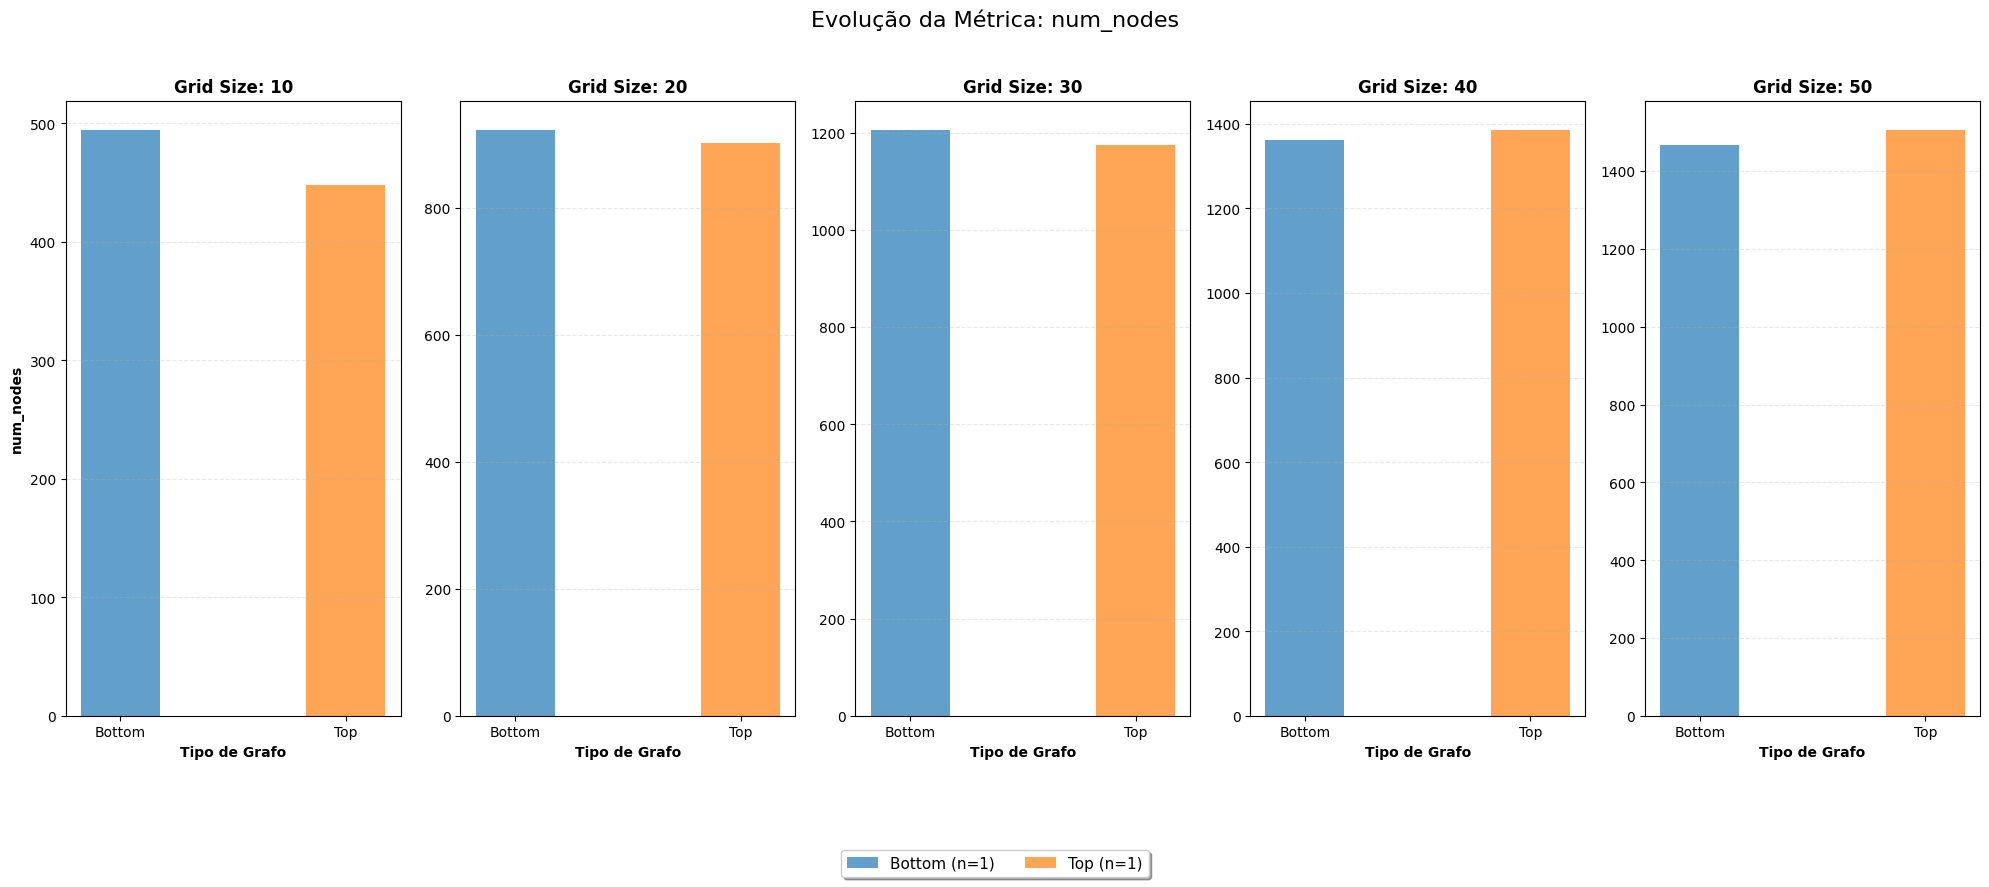

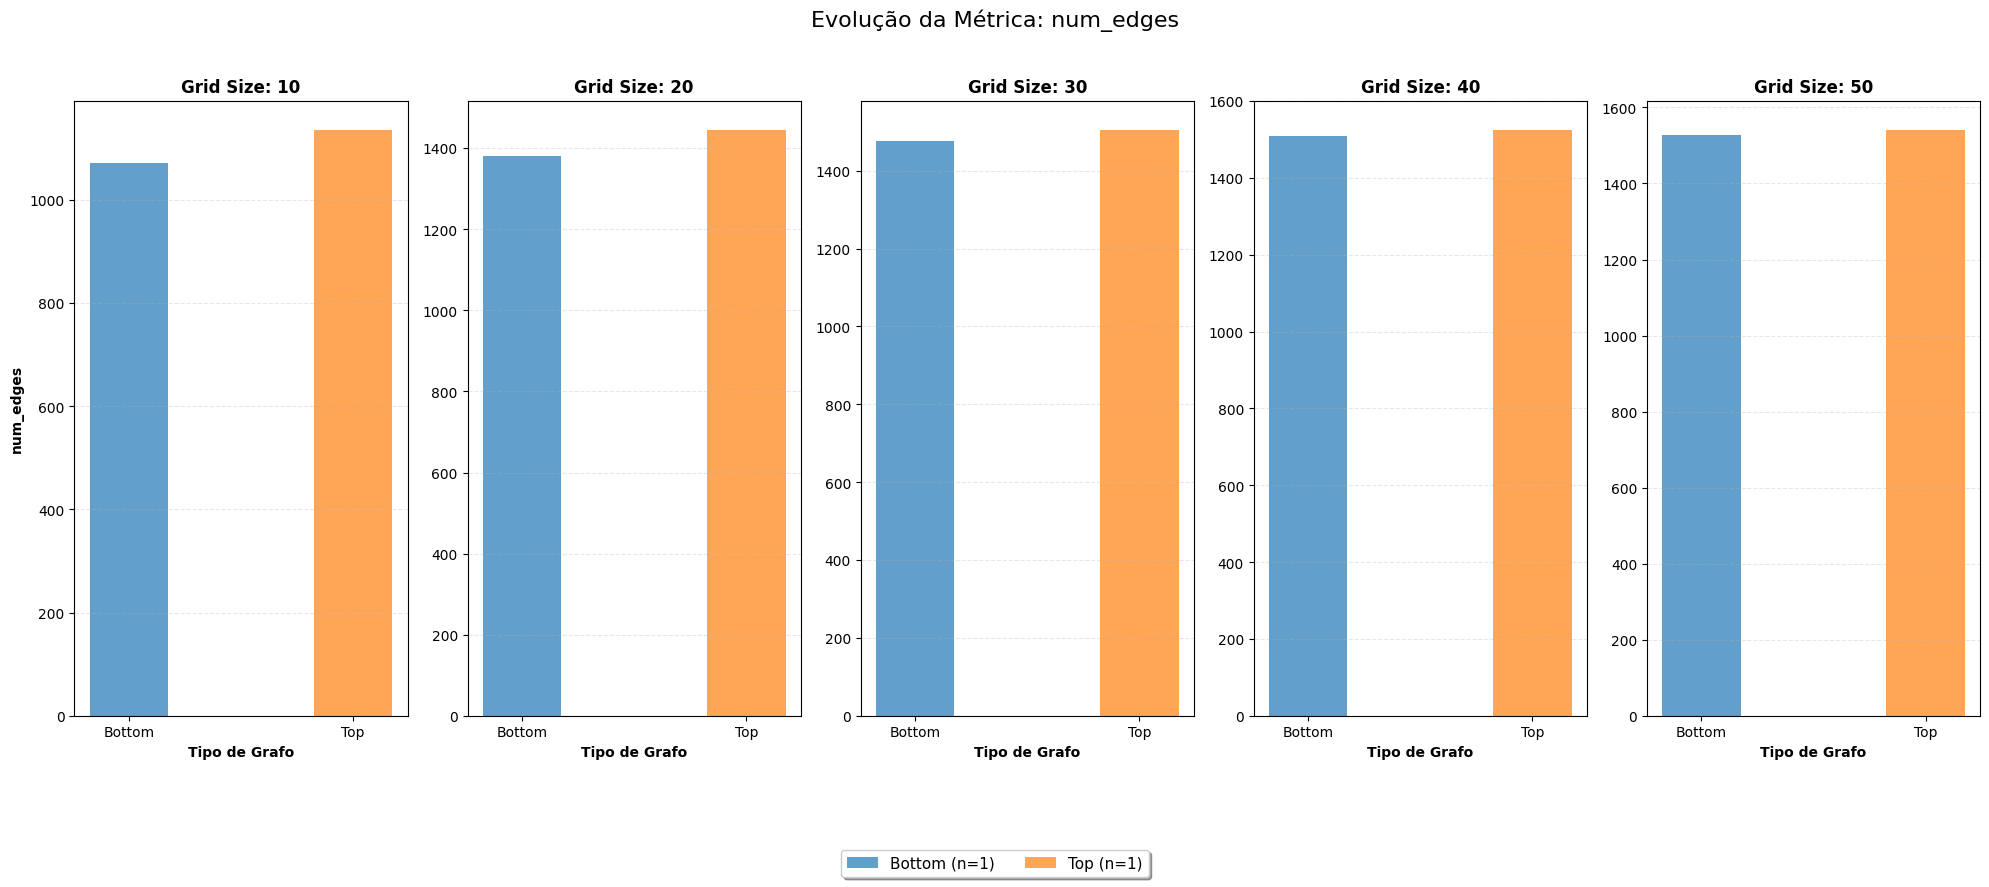

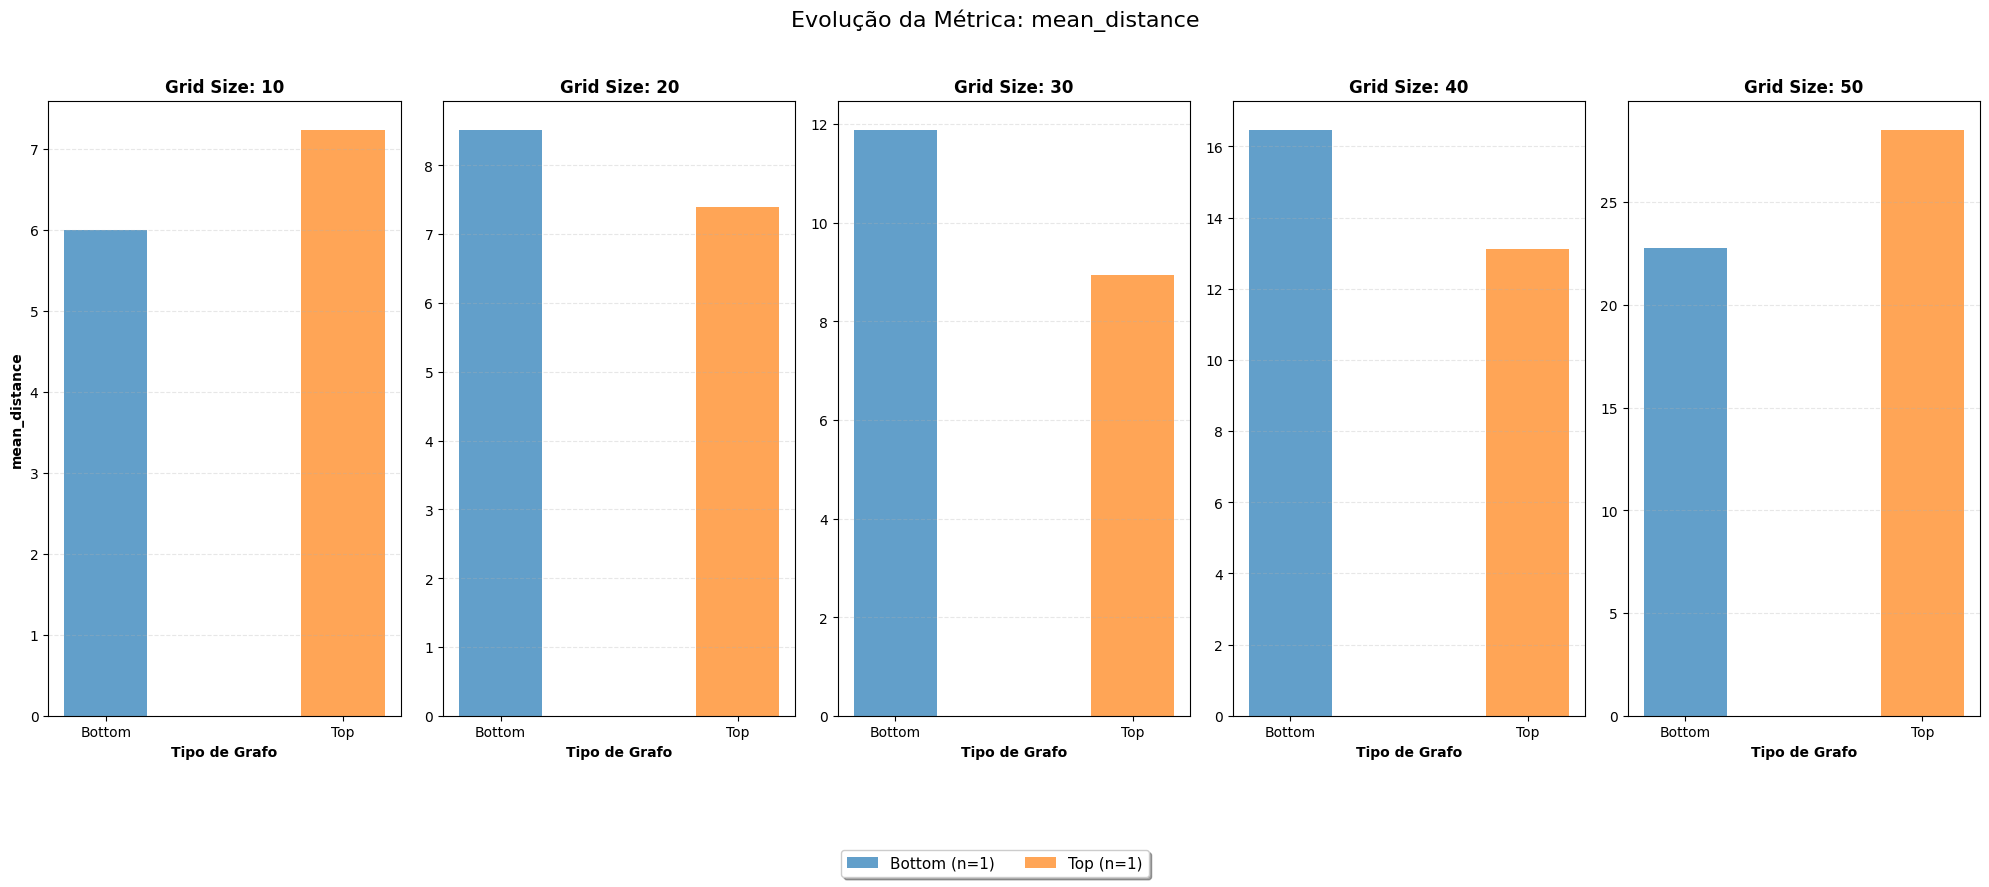

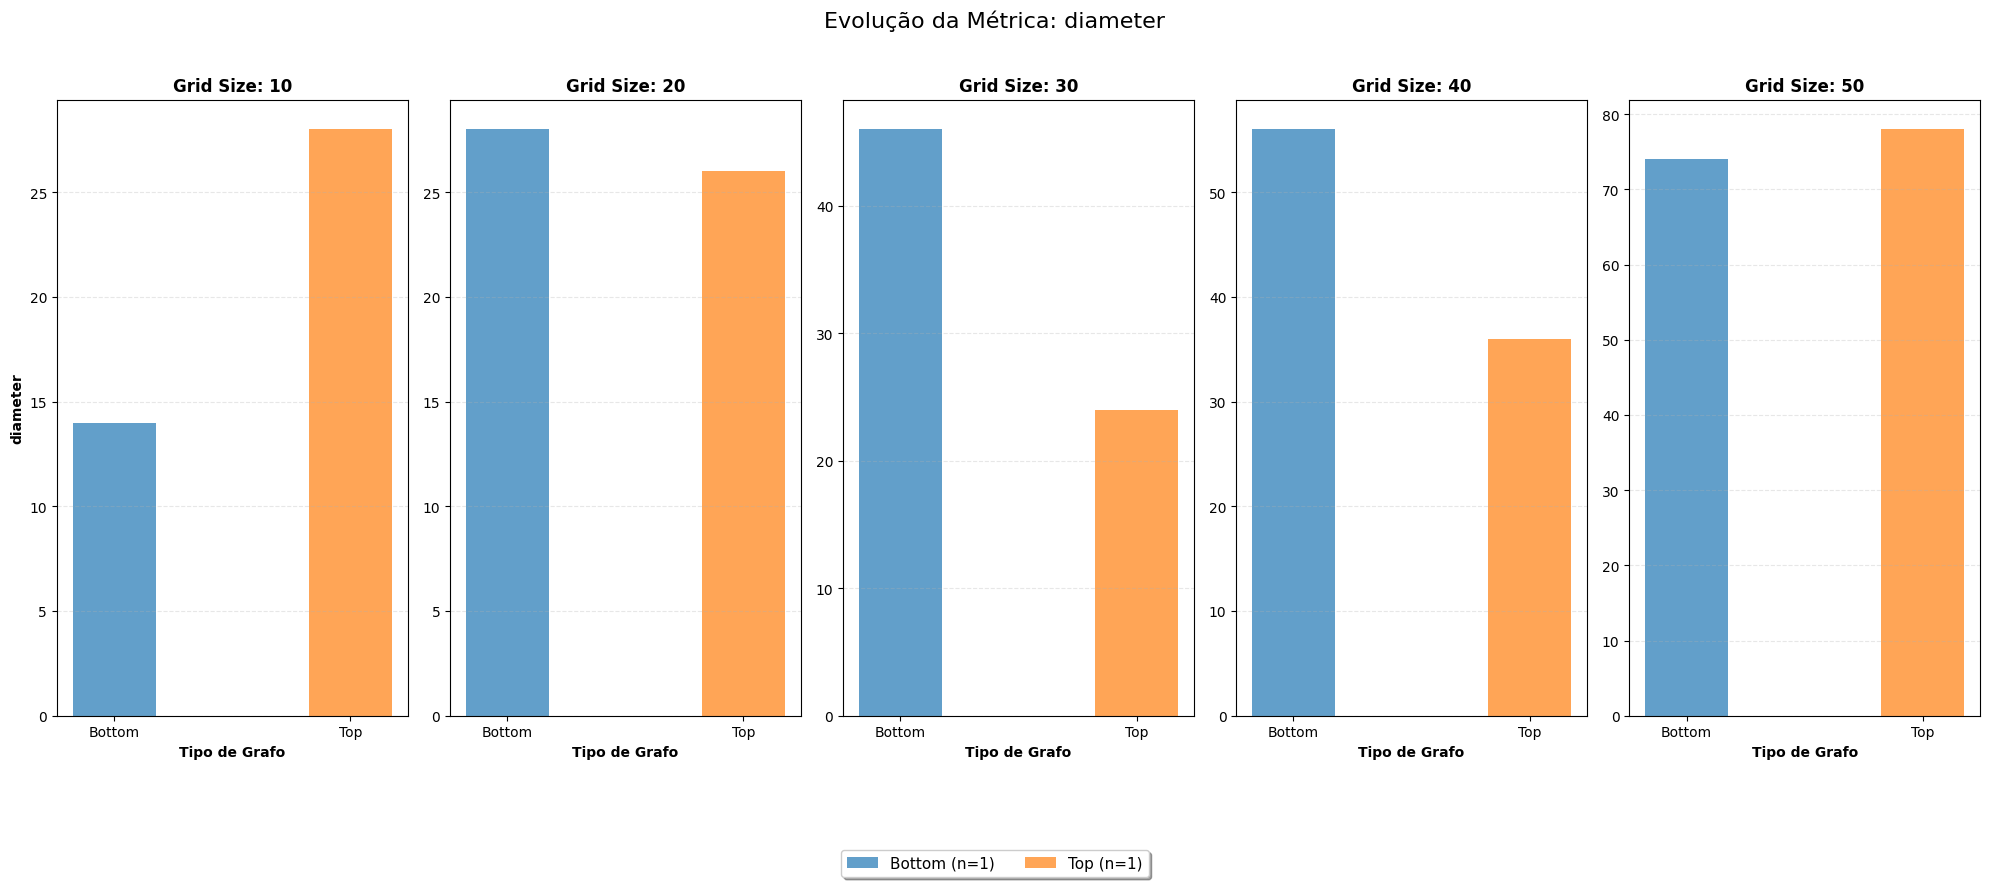

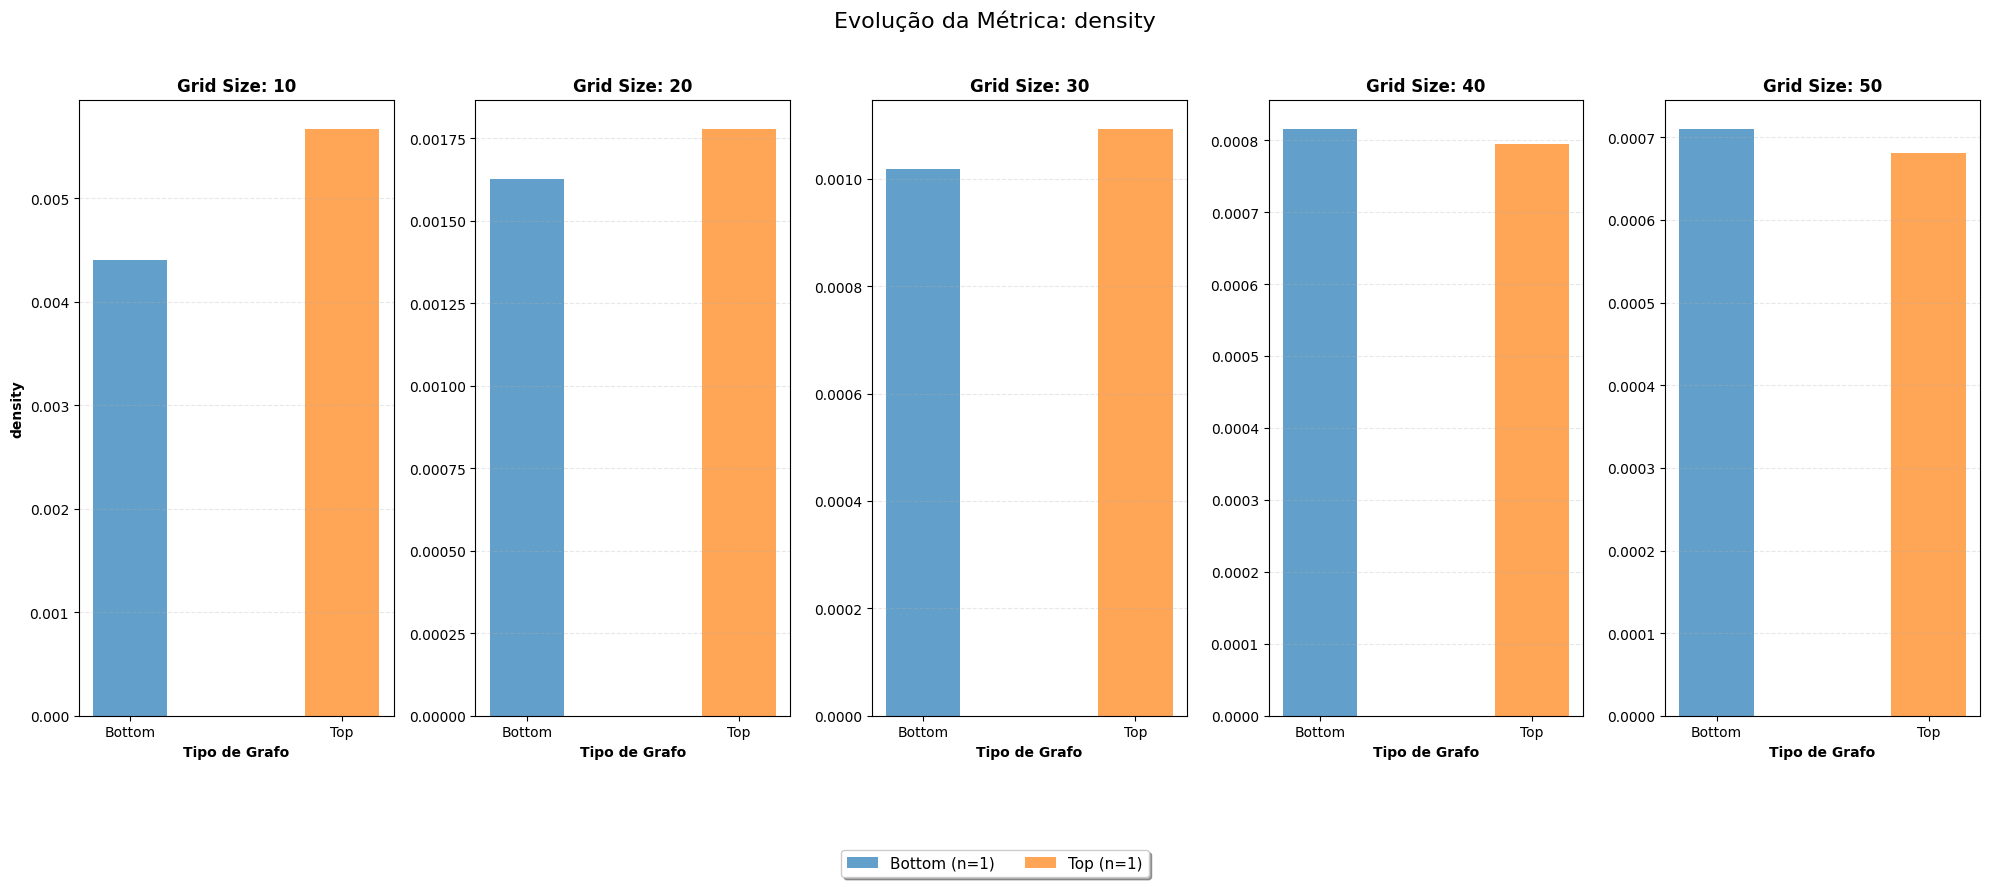

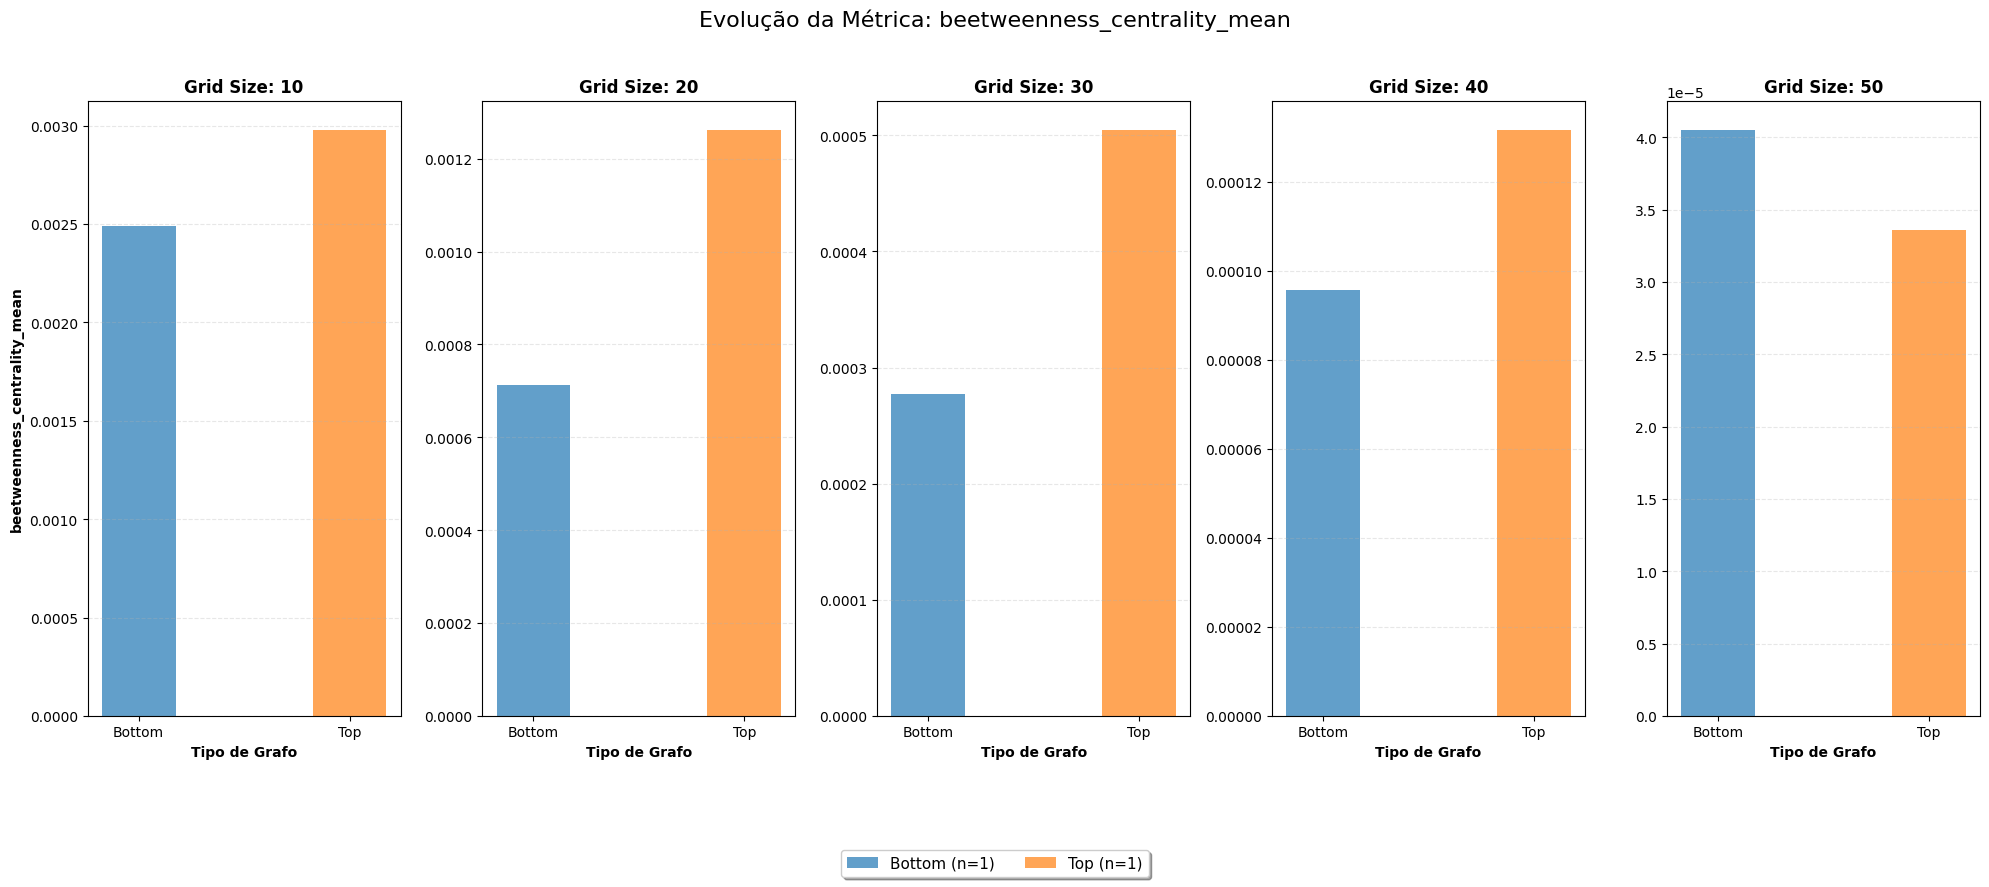

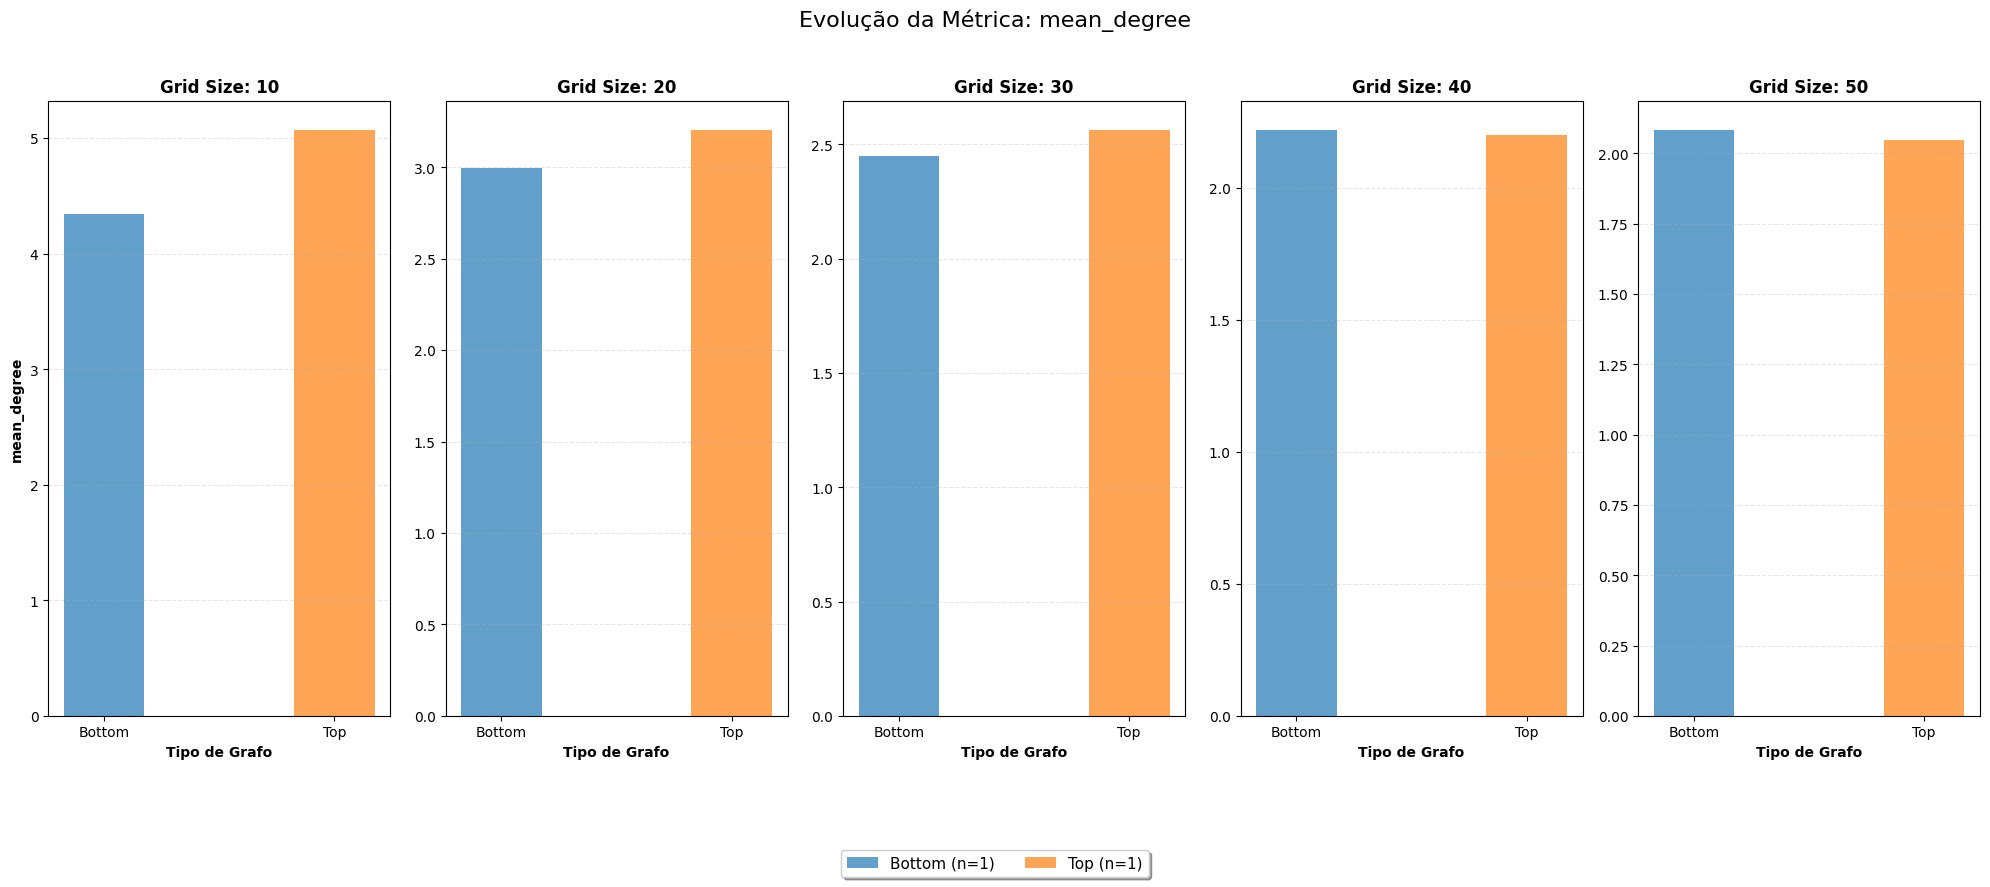

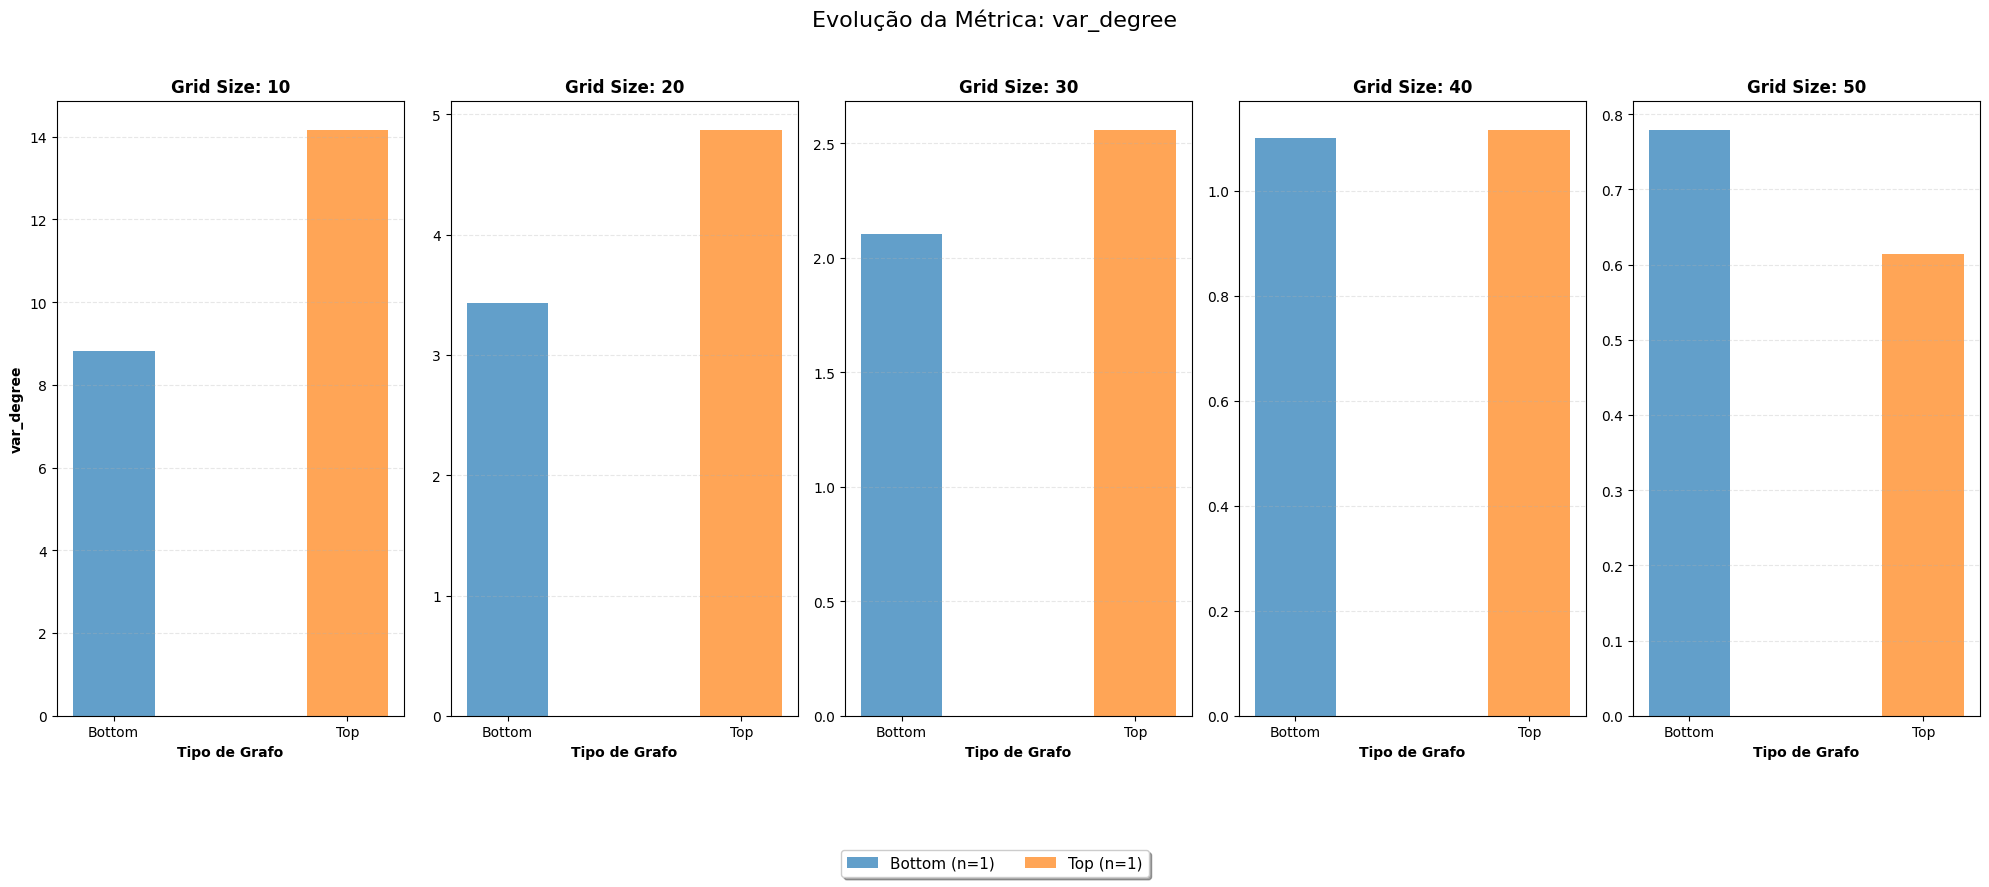

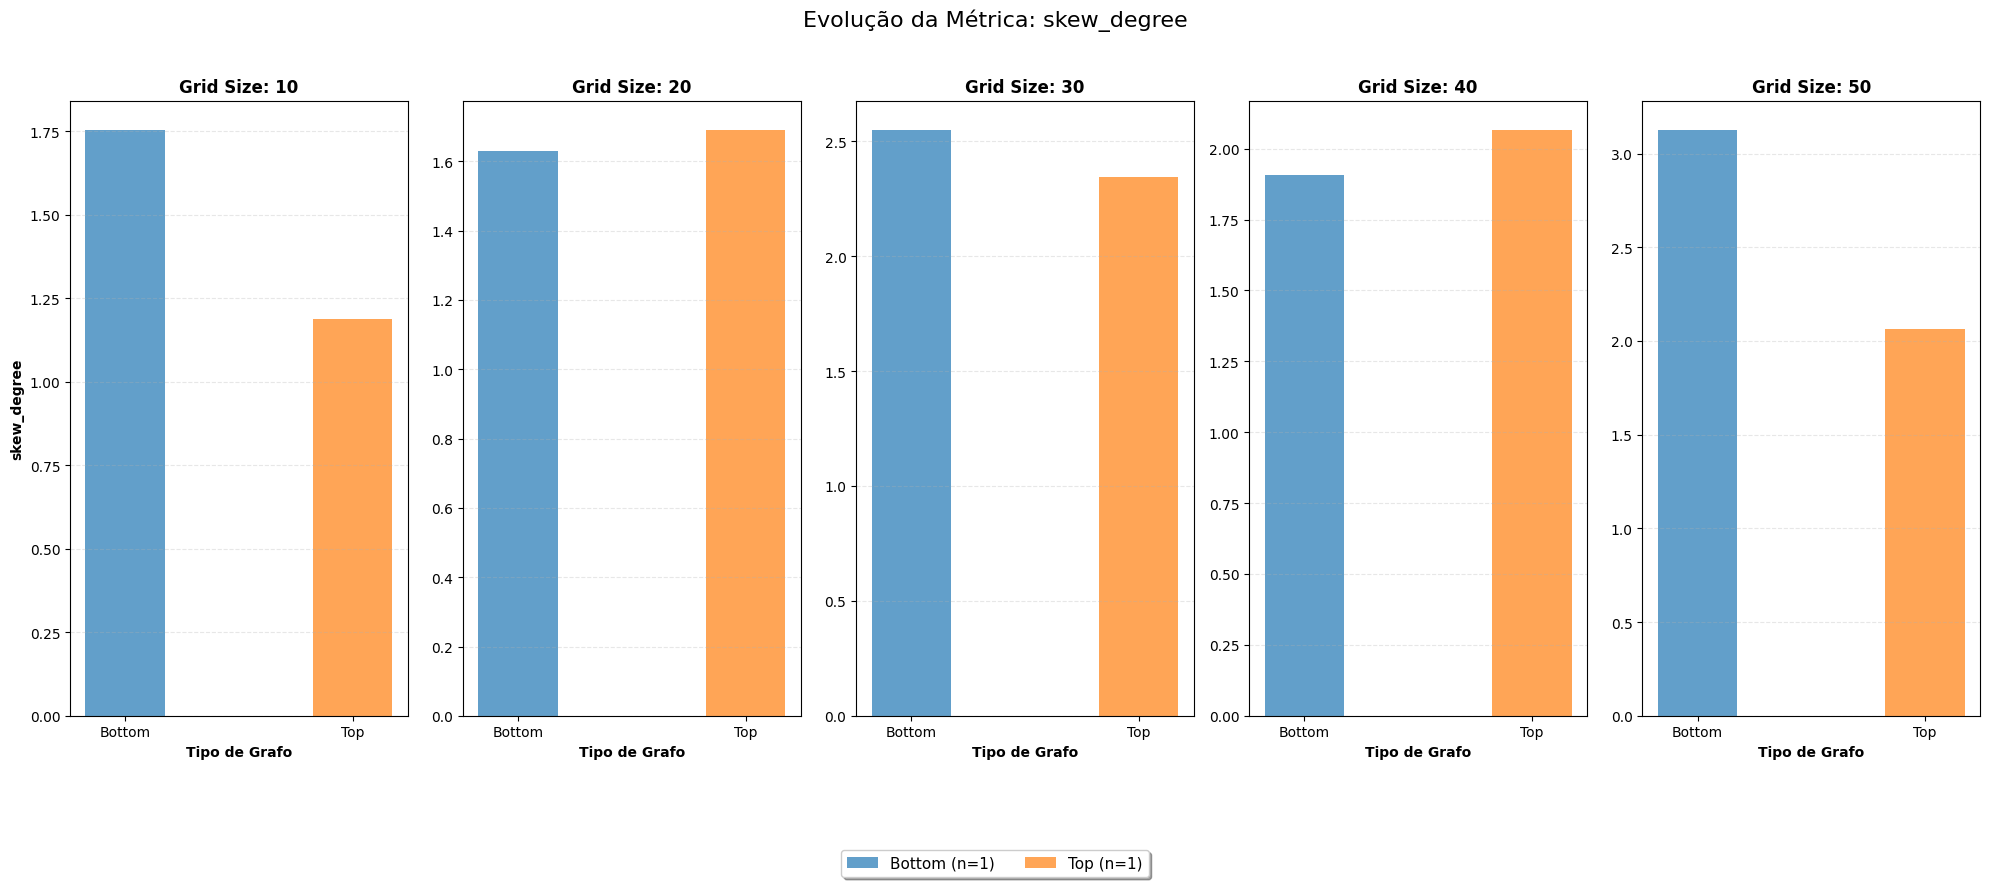

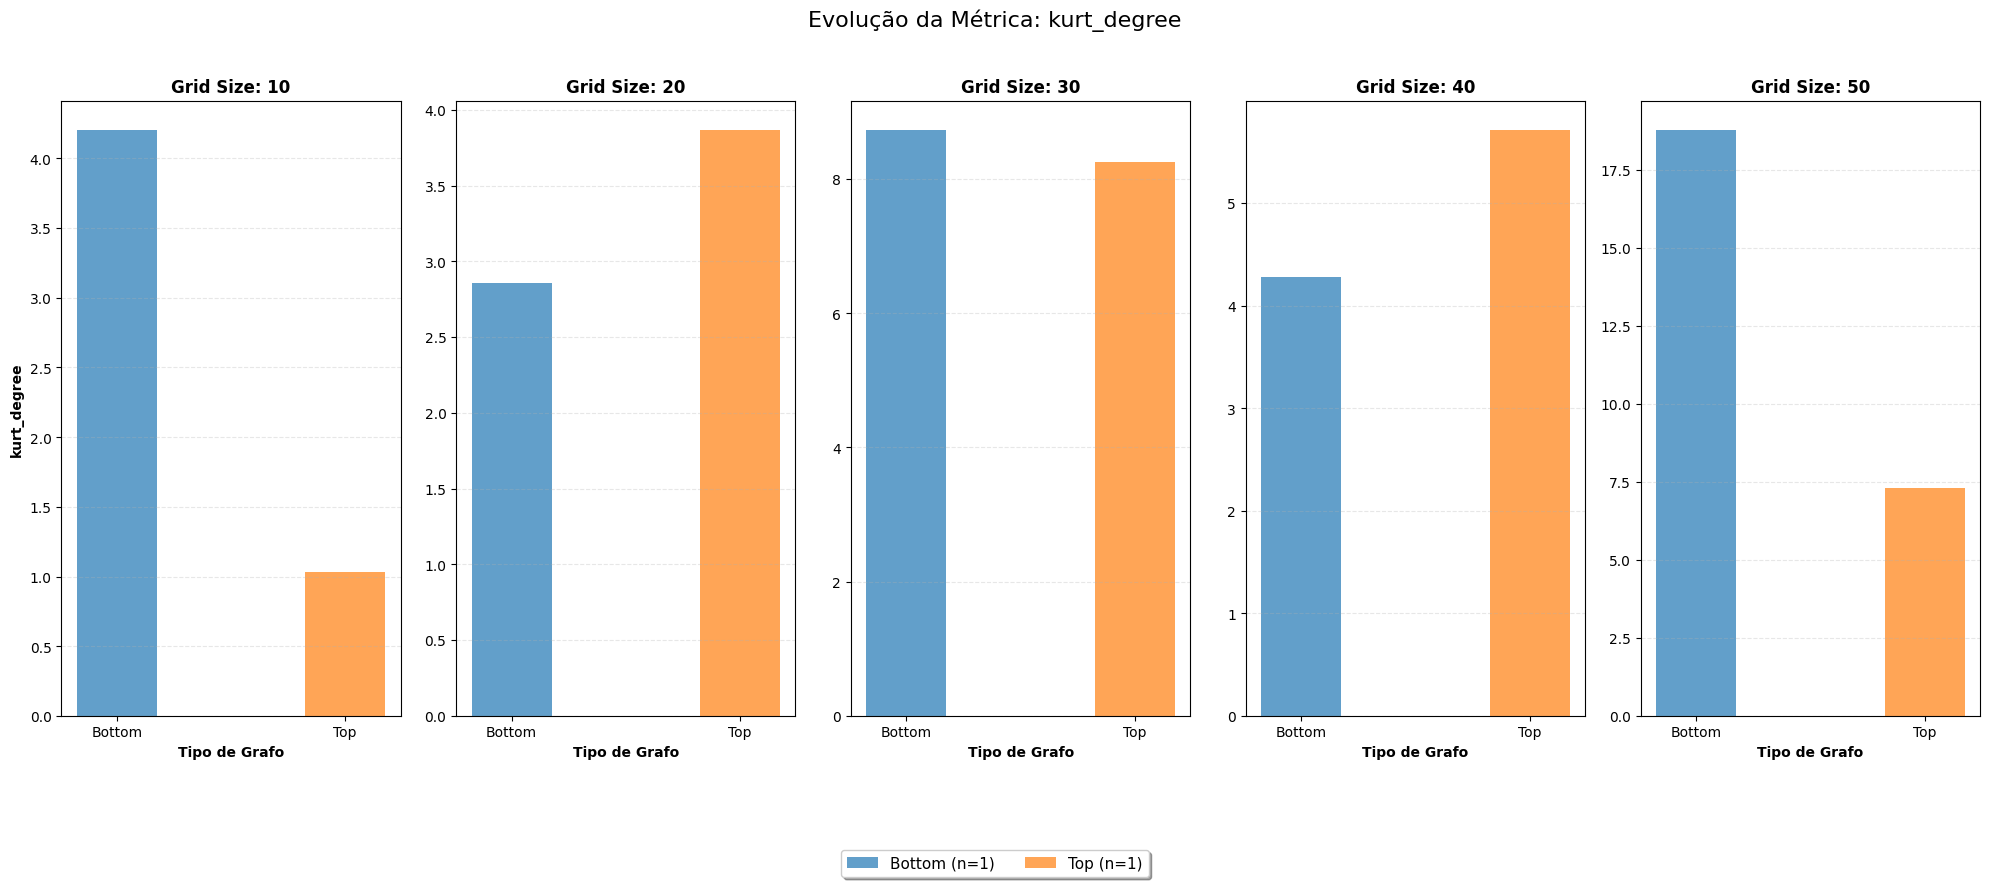

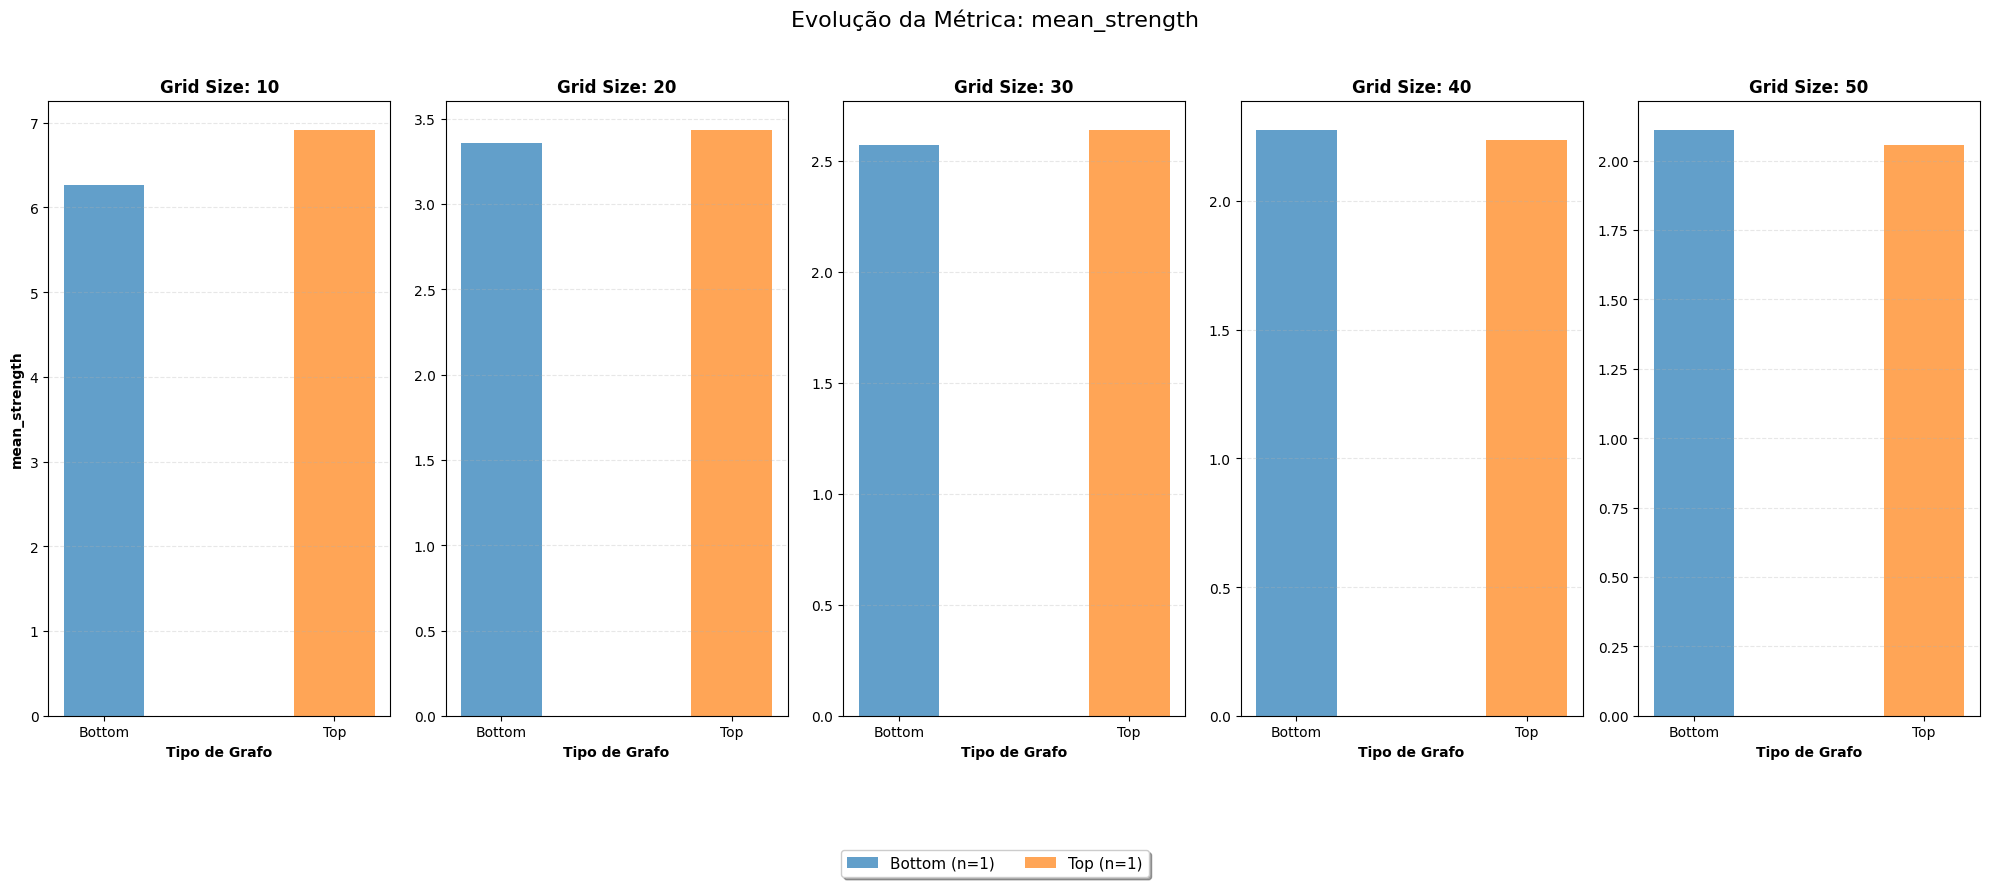

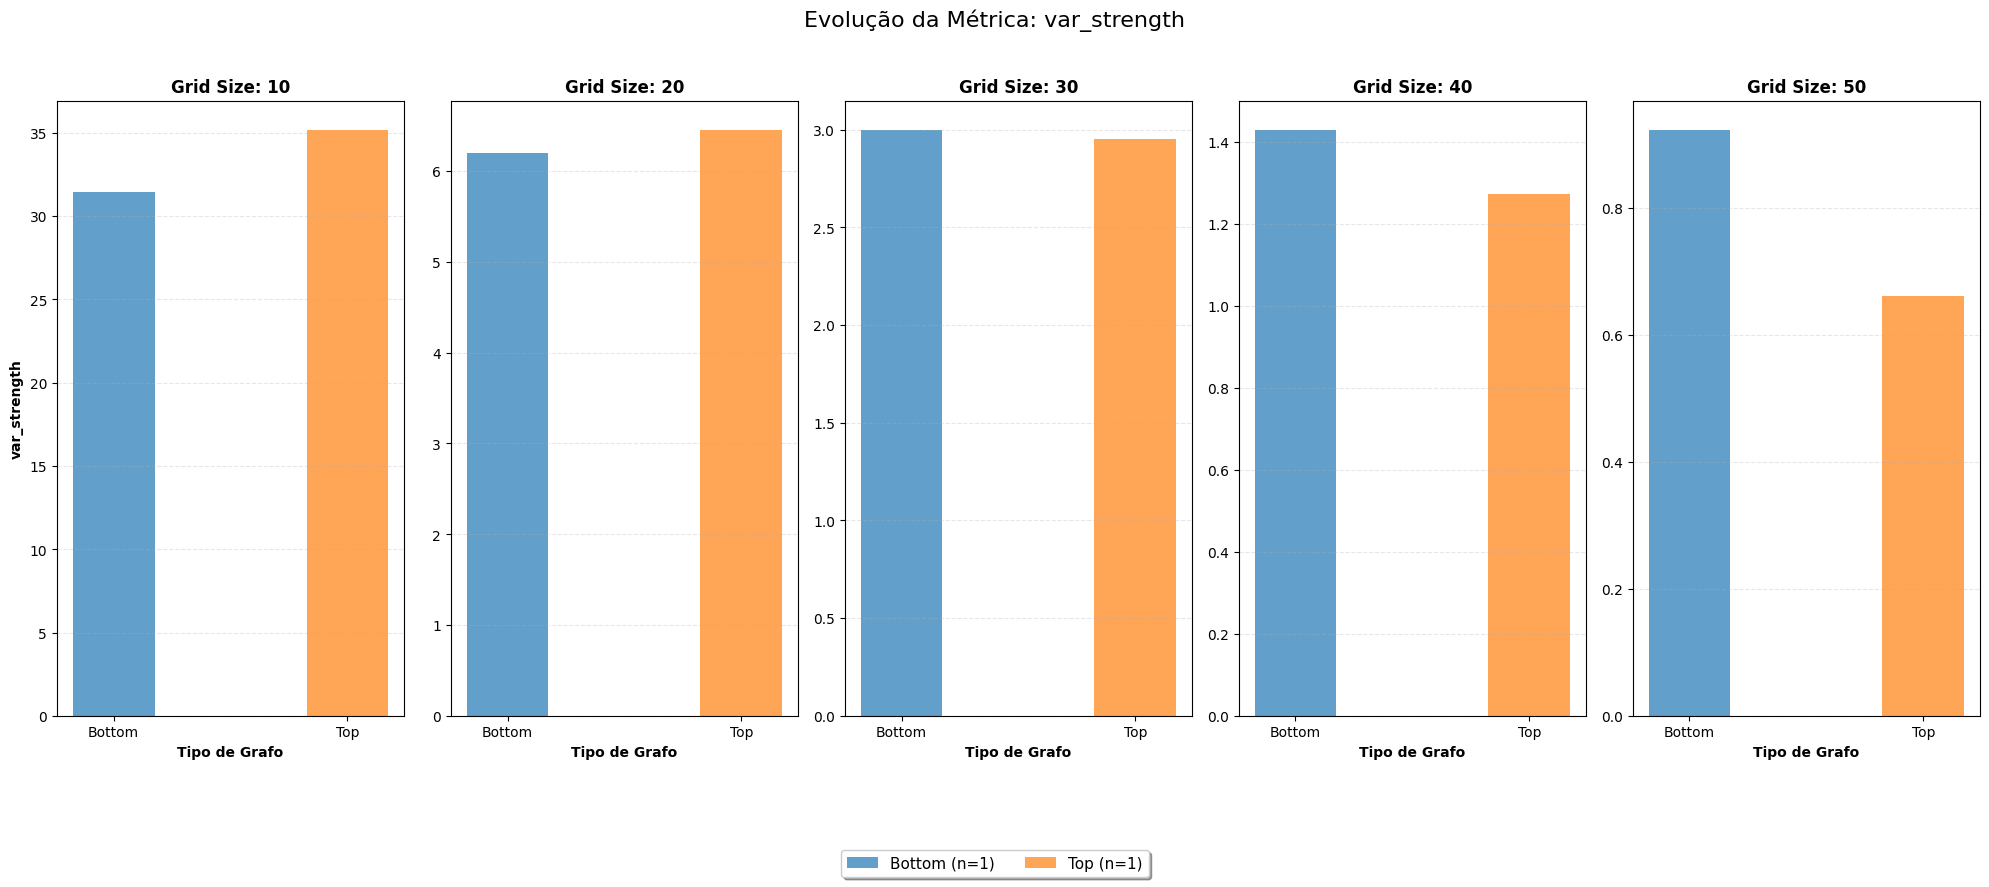

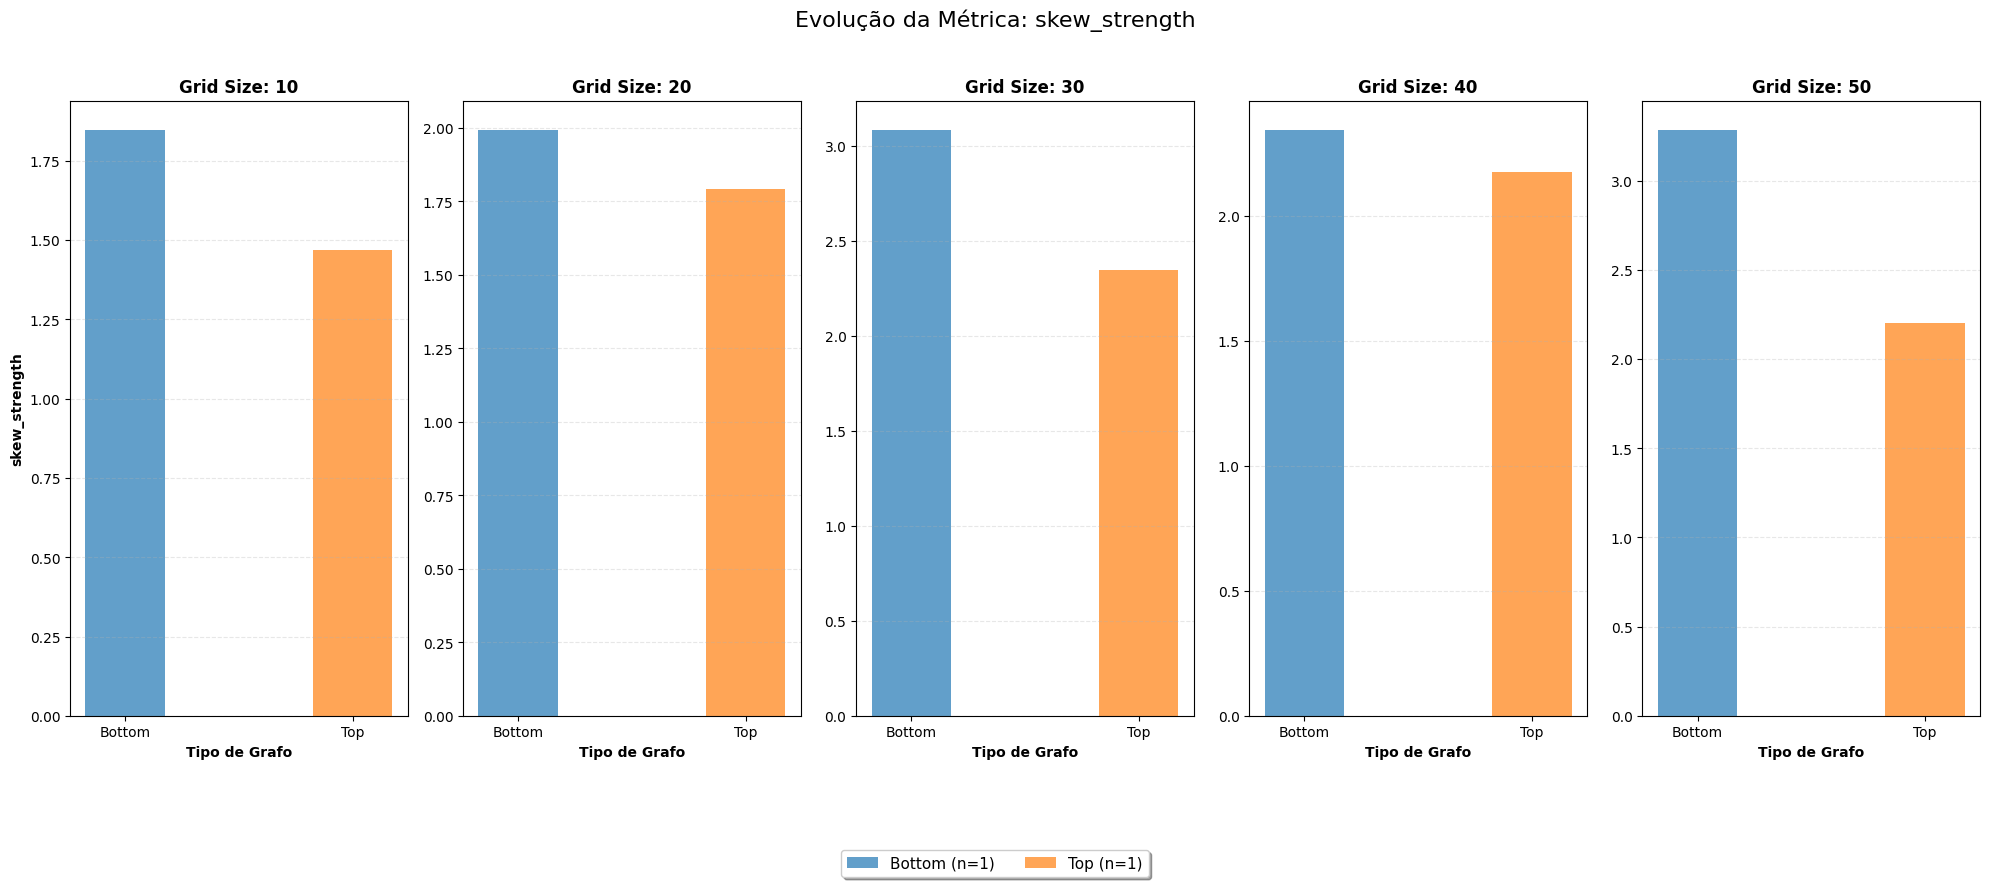

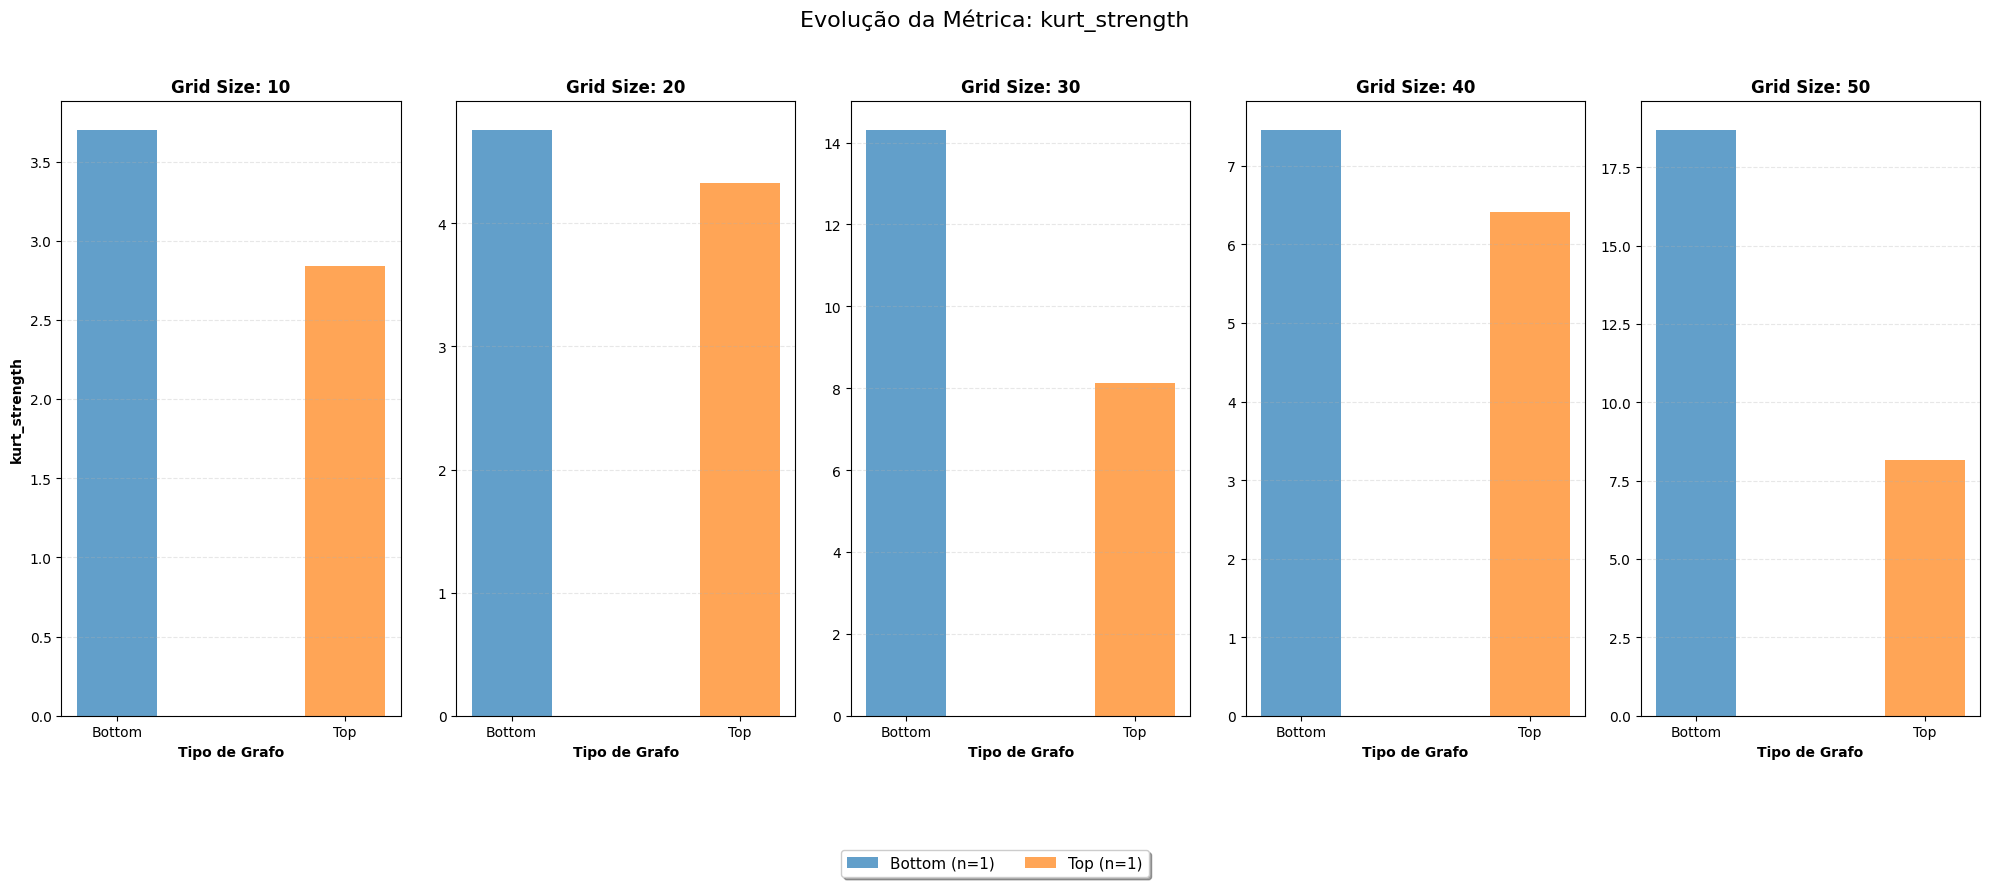

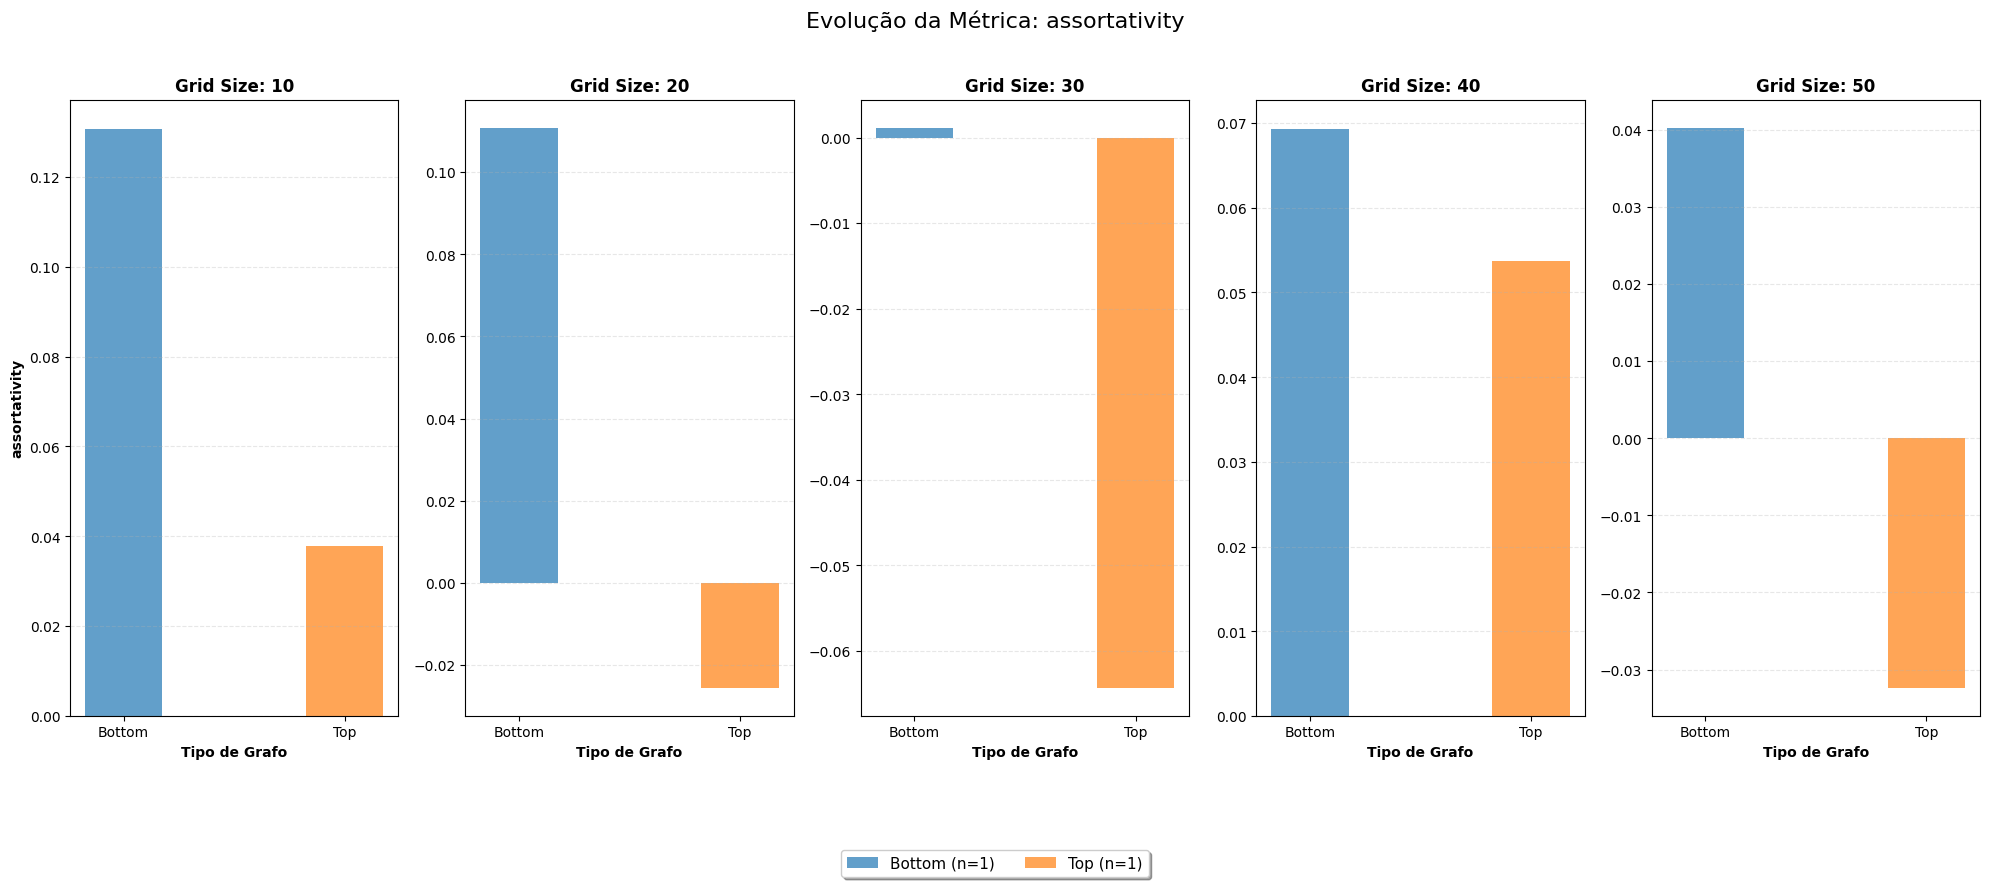

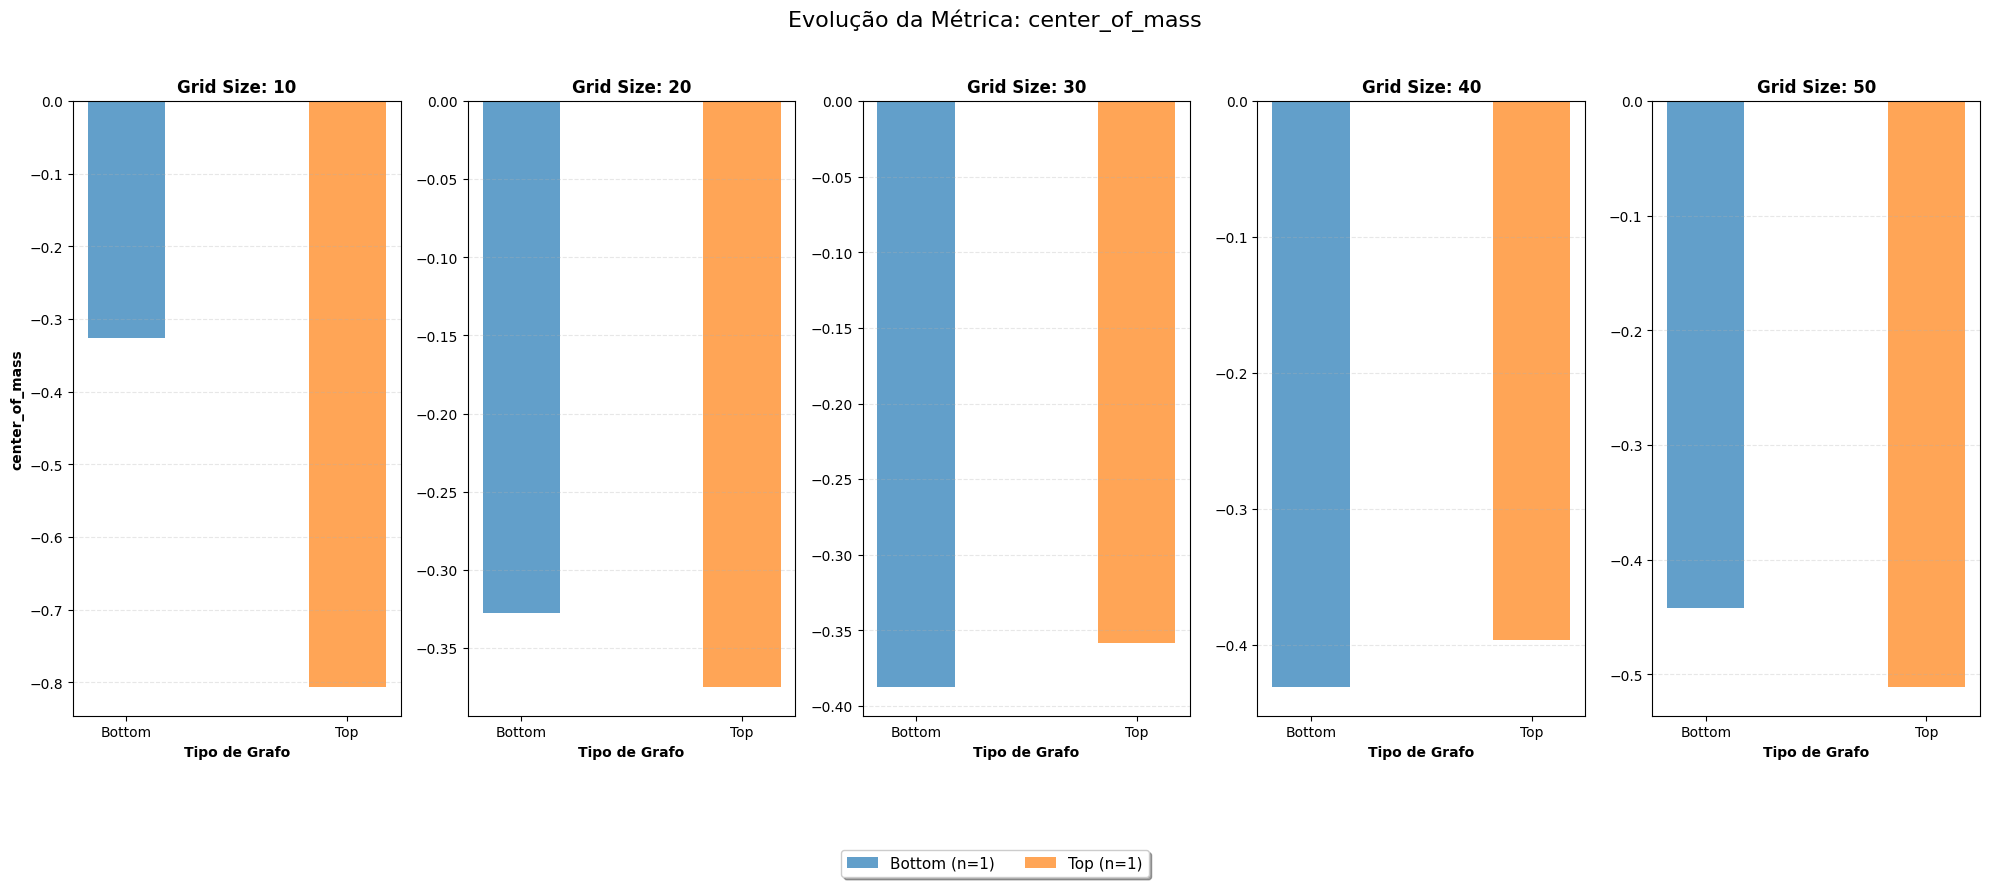


Foram gerados 16 gráficos (um para cada métrica).
Cada barra mostra: valor médio ± desvio padrão
Entre colchetes: [mínimo-máximo]


In [11]:
metrics_df = pd.read_csv(metrics_path)

# Primeiro, vamos identificar quais colunas são métricas (excluir colunas de identificação)
metric_columns = [col for col in metrics_df.columns 
                  if col not in ['grid_size', 'sample', 'graph_label', 'model_name', 'label', 'graph_label', 'center_of_strength']] # The center_of_strength is completely nan

print(f"Total de métricas encontradas: {len(metric_columns)}")
print(f"Métricas: {metric_columns}\n")

plot_metric_evolution_with_stats(metrics_df, metric_columns, GRID_SIZES)

In [12]:
def plot_cumulative_mean_by_metric(df, metric_columns, grid_sizes):
    """
    Plota a média acumulada dos experimentos para cada métrica.
    Para cada métrica, cria um gráfico com 2 subplots (um para true, outro para fake).
    Cada subplot mostra curvas para cada grid_size.
    Mostra a evolução da média acumulada conforme os experimentos progridem.
    """
    
    # Cores para cada grid_size
    colors = plt.cm.Set1(np.linspace(0, 1, len(grid_sizes)))
    
    for metric in metric_columns:
        # Criar figura com 2 subplots (true e fake)
        fig, axes = plt.subplots(
            1, 
            2, 
            figsize=(16, 6),
            sharey=True
        )
        
        fig.suptitle(f'Média Acumulada - Métrica: {metric}', fontsize=16, y=0.98)
        
        # Iterar sobre cada label (true, fake)
        labels = ['bottom', 'top']
        for col, label in enumerate(labels):
            ax = axes[col]
            
            # Iterar sobre cada grid_size
            for grid_idx, grid_size in enumerate(grid_sizes):
                # Filtrar dados para grid_size e label específicos
                df_filtered = df[(df['grid_size'] == grid_size) & (df['graph_label'] == label)].copy()
                df_filtered = df_filtered.sort_values('sample')
                
                if len(df_filtered) > 0:
                    # Calcular a média acumulada
                    df_filtered['cumulative_mean'] = df_filtered[metric].expanding().mean()
                    
                    # Plotar linha de média acumulada
                    ax.plot(
                        df_filtered['sample'],
                        df_filtered['cumulative_mean'],
                        linewidth=2.5,
                        color=colors[grid_idx],
                        marker='o',
                        markersize=2,
                        alpha=0.8,
                        label=f'Grid Size: {grid_size}'
                    )
                    
                    # Preencher área sob a curva com transparência
                    # ax.fill_between(
                    #     df_filtered['sample'],
                    #     df_filtered['cumulative_mean'],
                    #     alpha=0.1,
                    #     color=colors[grid_idx]
                    # )
            
            # Adicionar grid
            ax.grid(True, linestyle='--', alpha=0.3)
            
            # Títulos e labels
            ax.set_title(f'{label.capitalize()}', fontsize=13, fontweight='bold')
            ax.set_xlabel('Sample #', fontweight='bold', fontsize=11)
            
            # Label Y apenas no primeiro subplot
            if col == 0:
                ax.set_ylabel(metric, fontweight='bold', fontsize=11)
            
            # Legenda
            ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nForam gerados {len(metric_columns)} gráficos de média acumulada.")
    print("Cada gráfico mostra: 2 subplots (true/fake) com curvas para cada grid_size")
    print("A curva mostra a evolução da média conforme os experimentos progridem.")

Total de métricas encontradas: 16
Métricas: ['num_nodes', 'num_edges', 'mean_distance', 'diameter', 'density', 'beetweenness_centrality_mean', 'mean_degree', 'var_degree', 'skew_degree', 'kurt_degree', 'mean_strength', 'var_strength', 'skew_strength', 'kurt_strength', 'assortativity', 'center_of_mass']



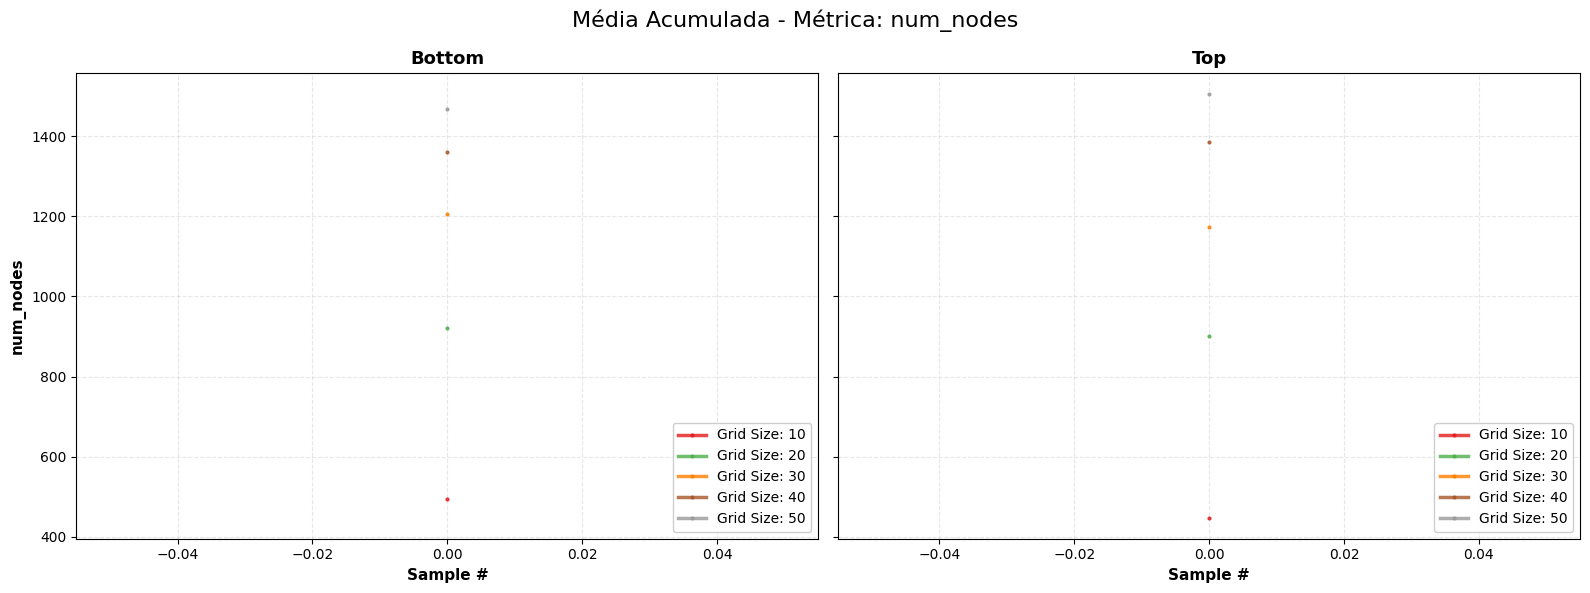

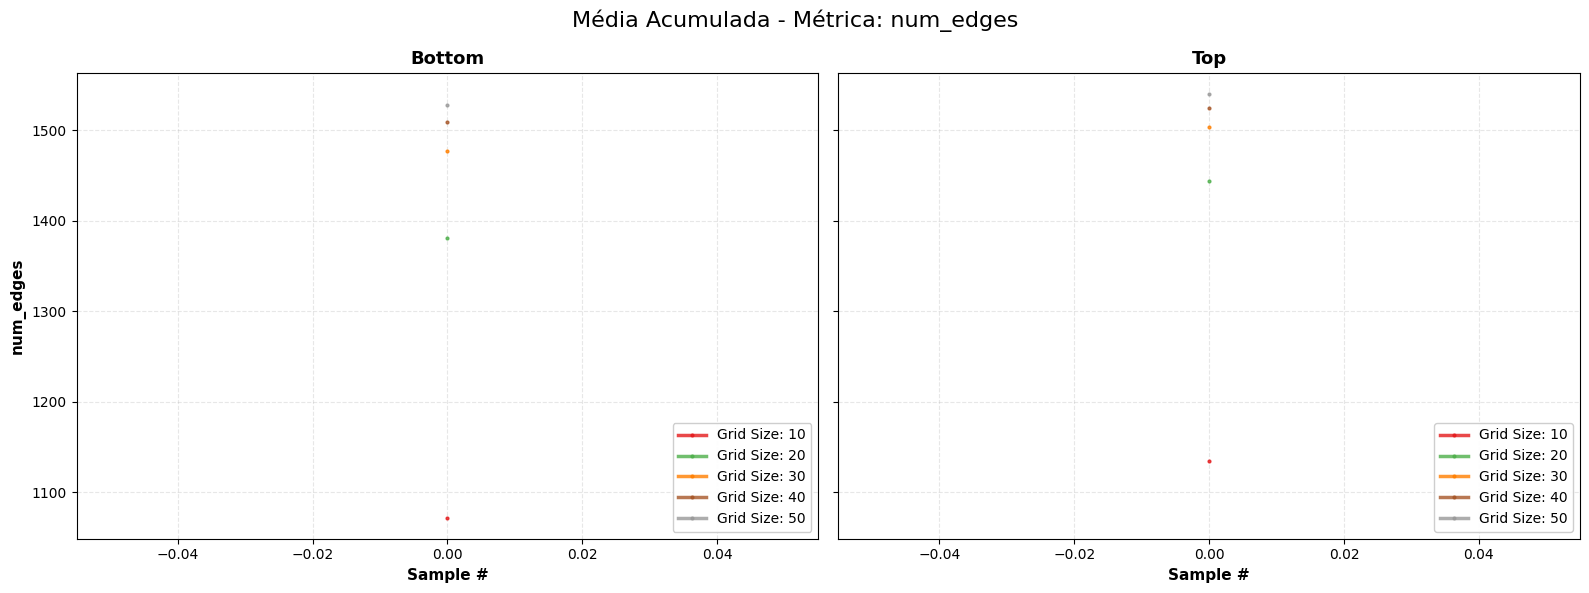

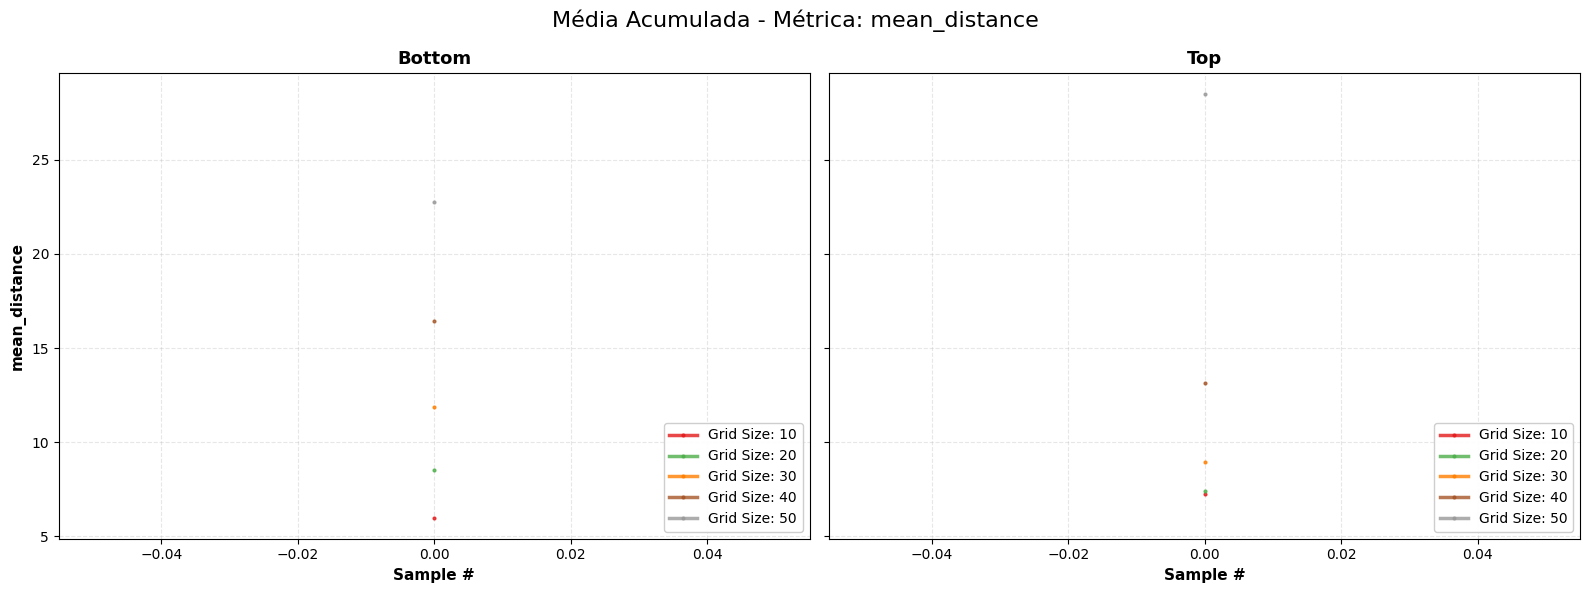

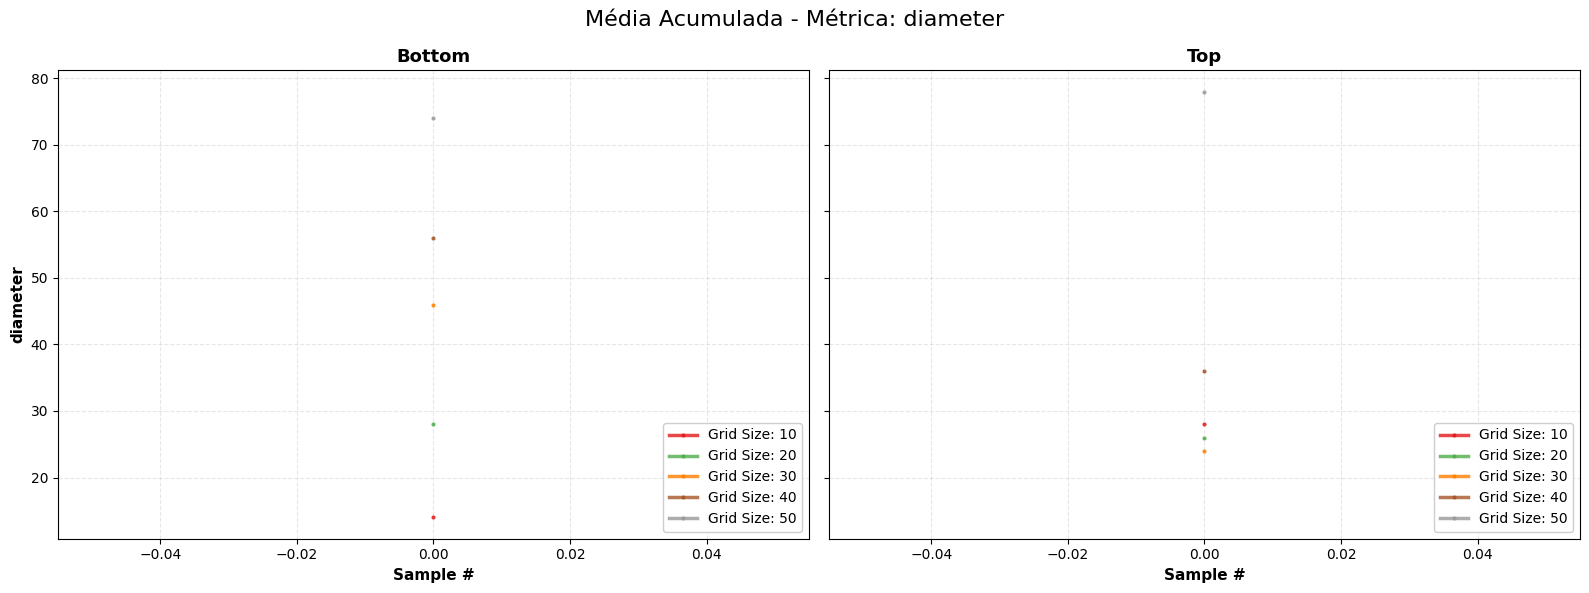

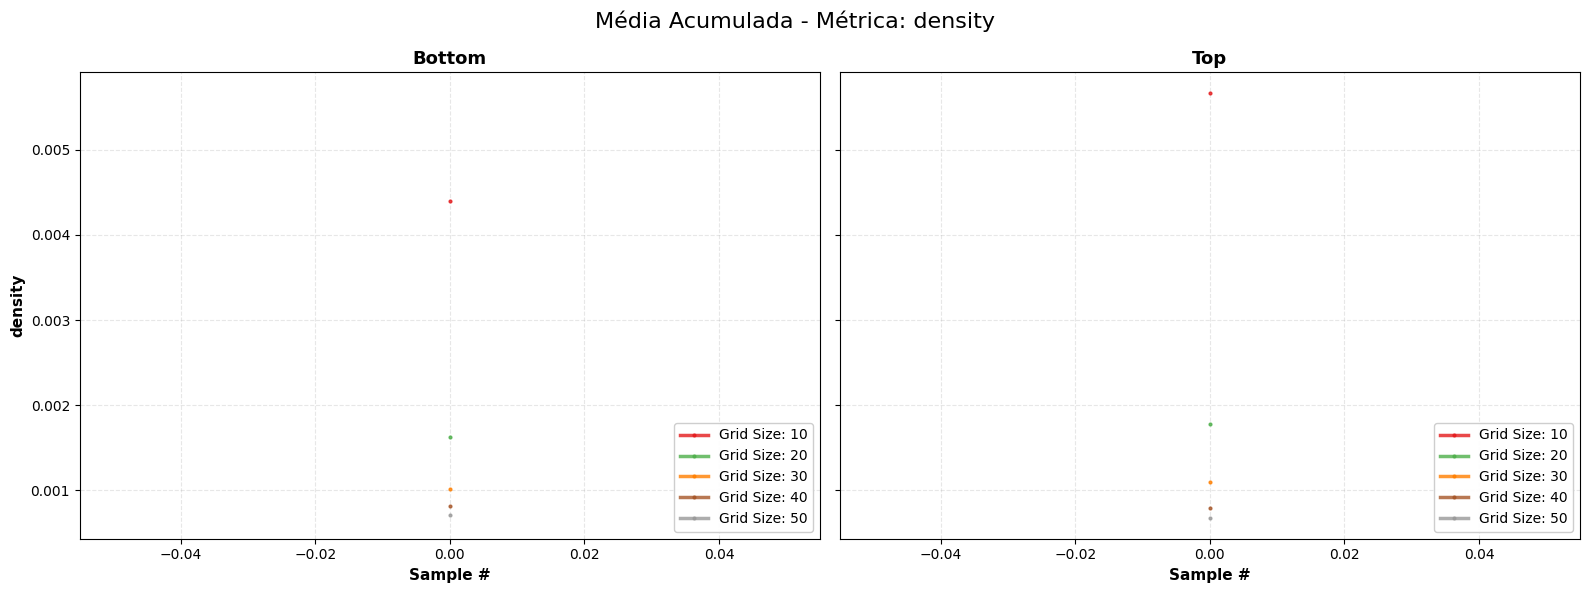

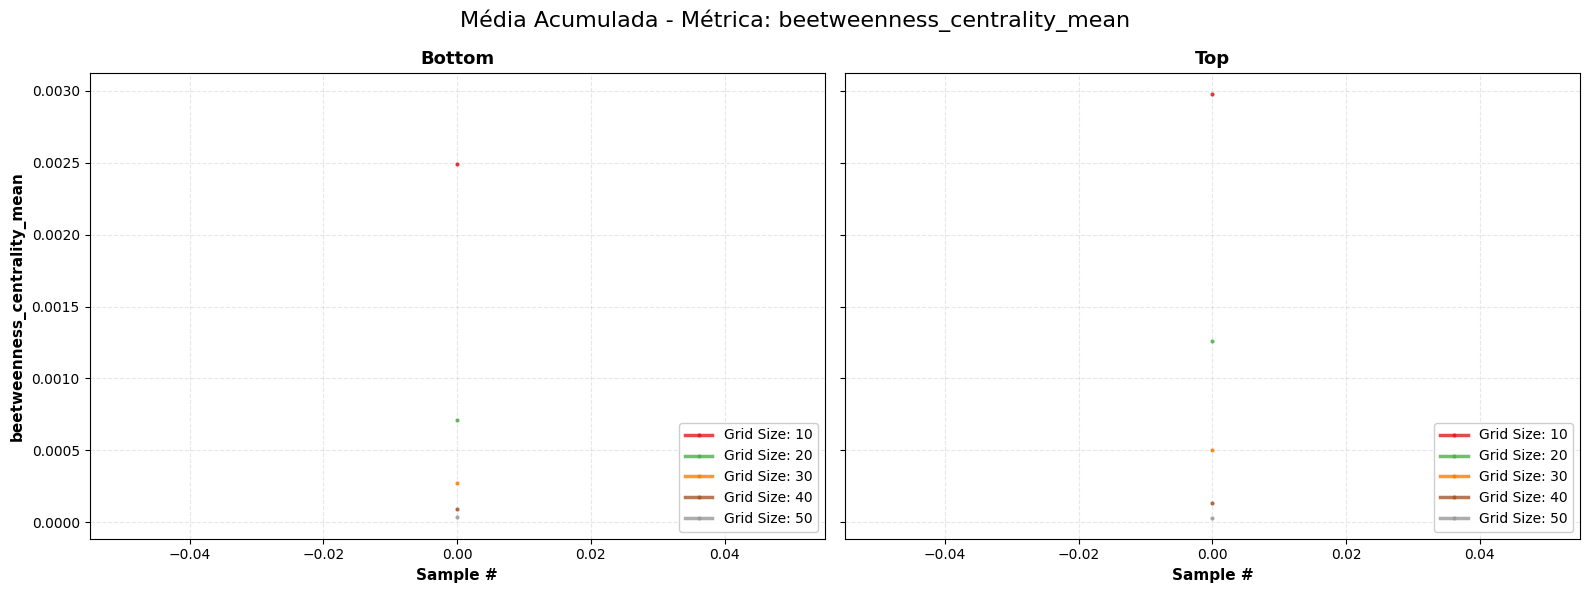

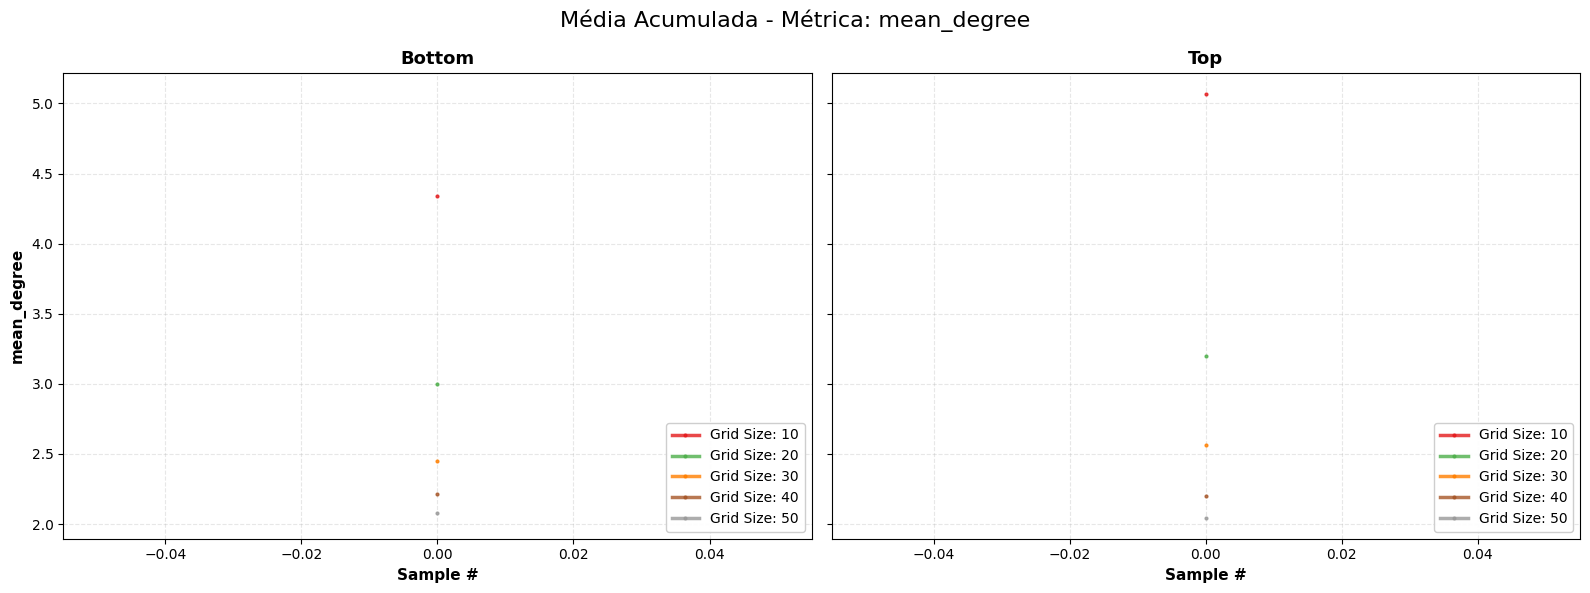

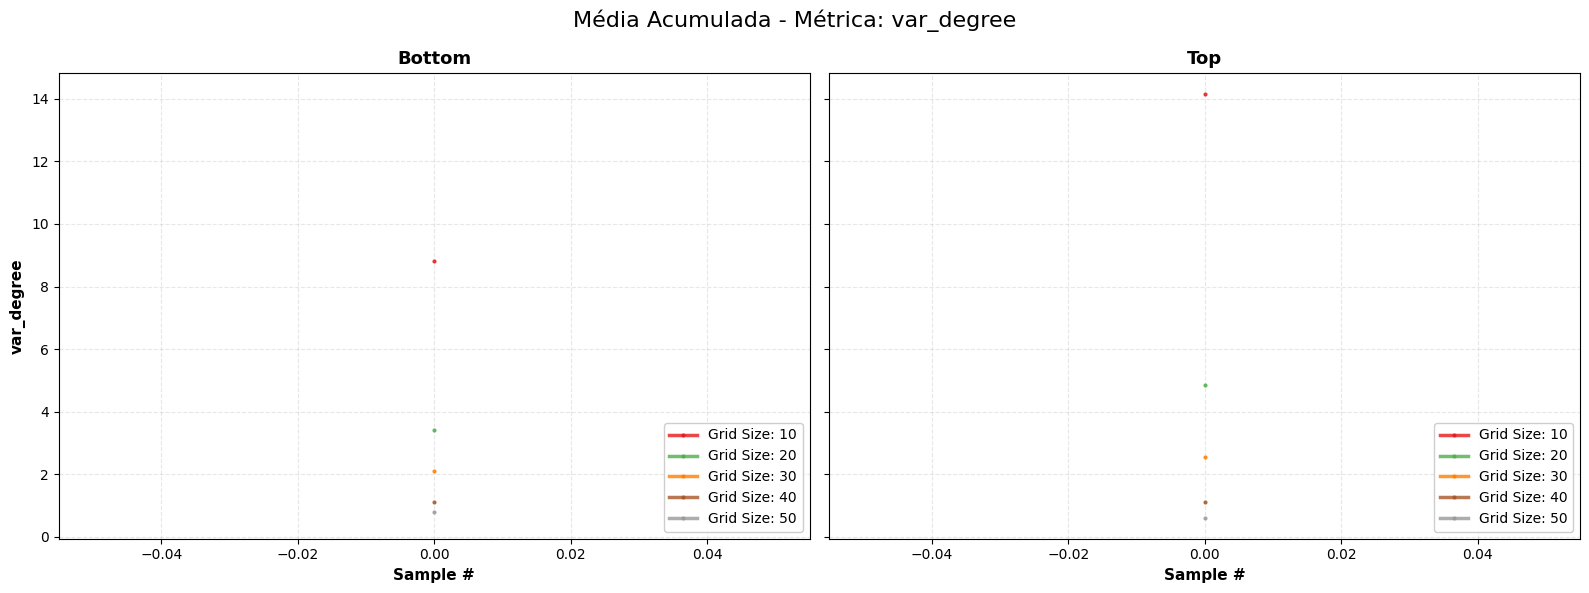

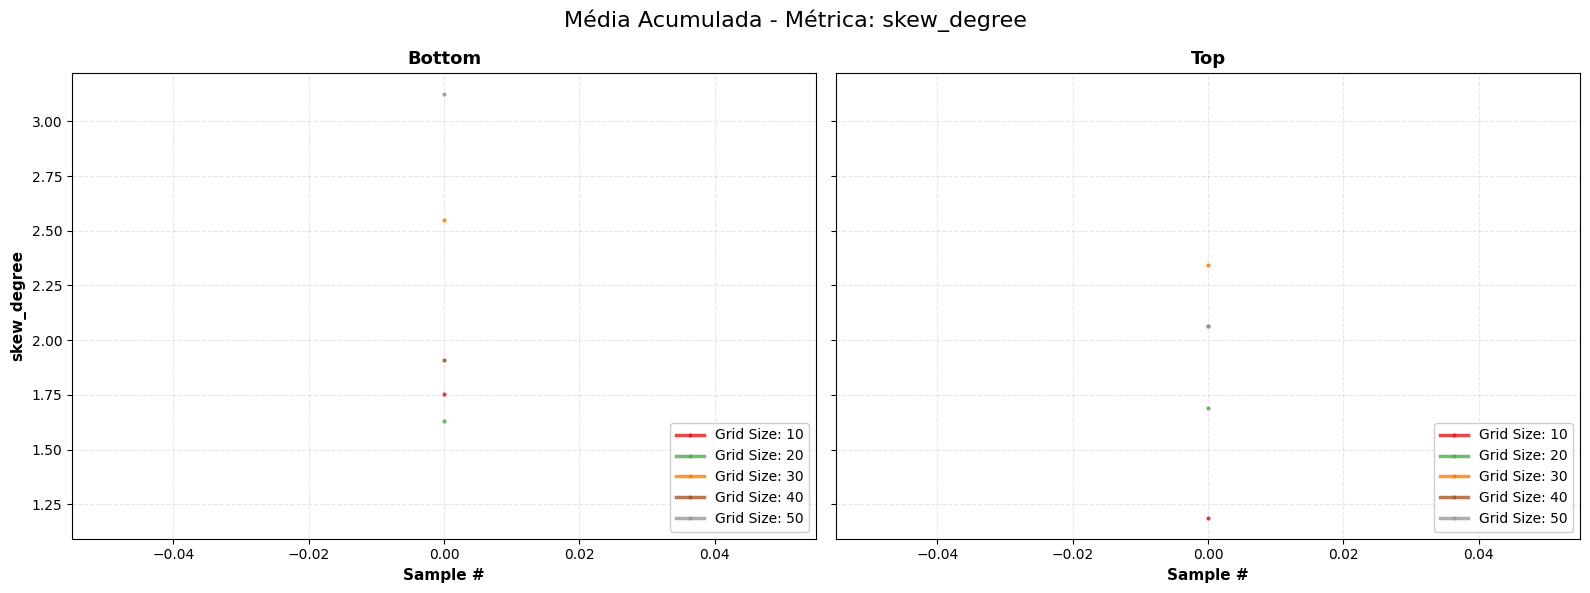

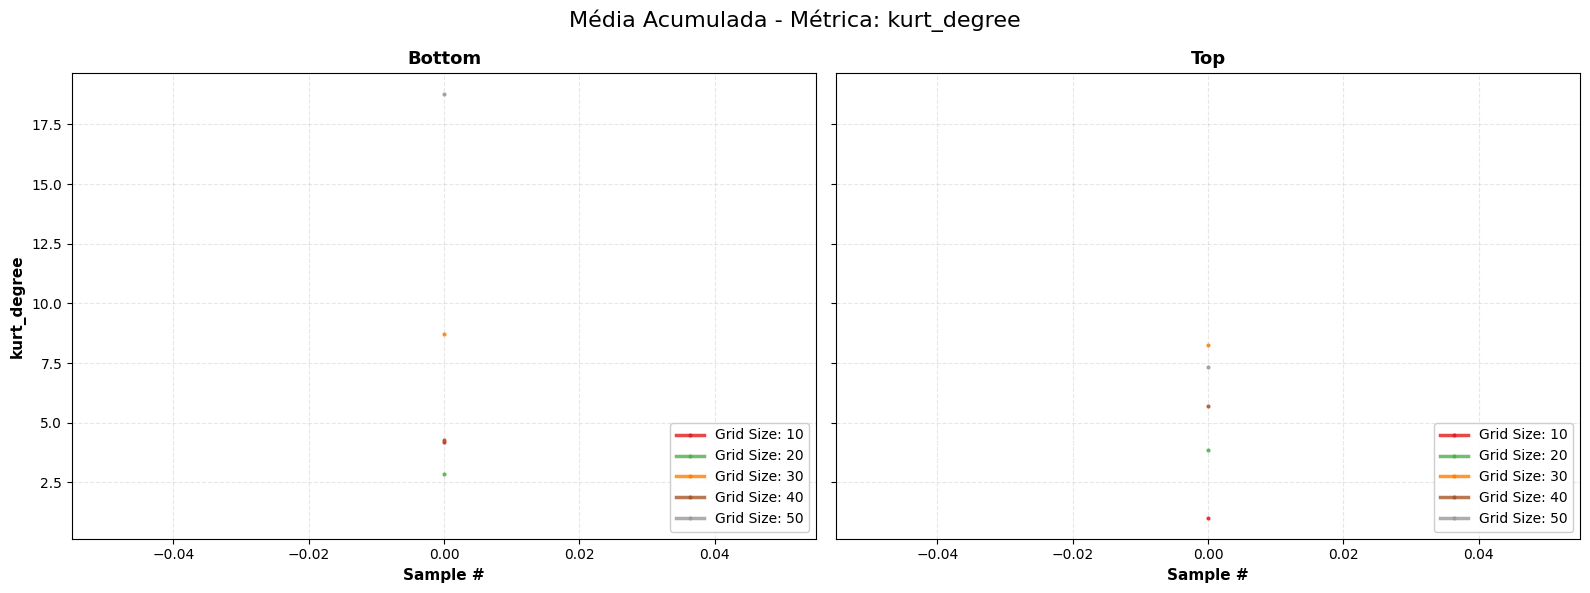

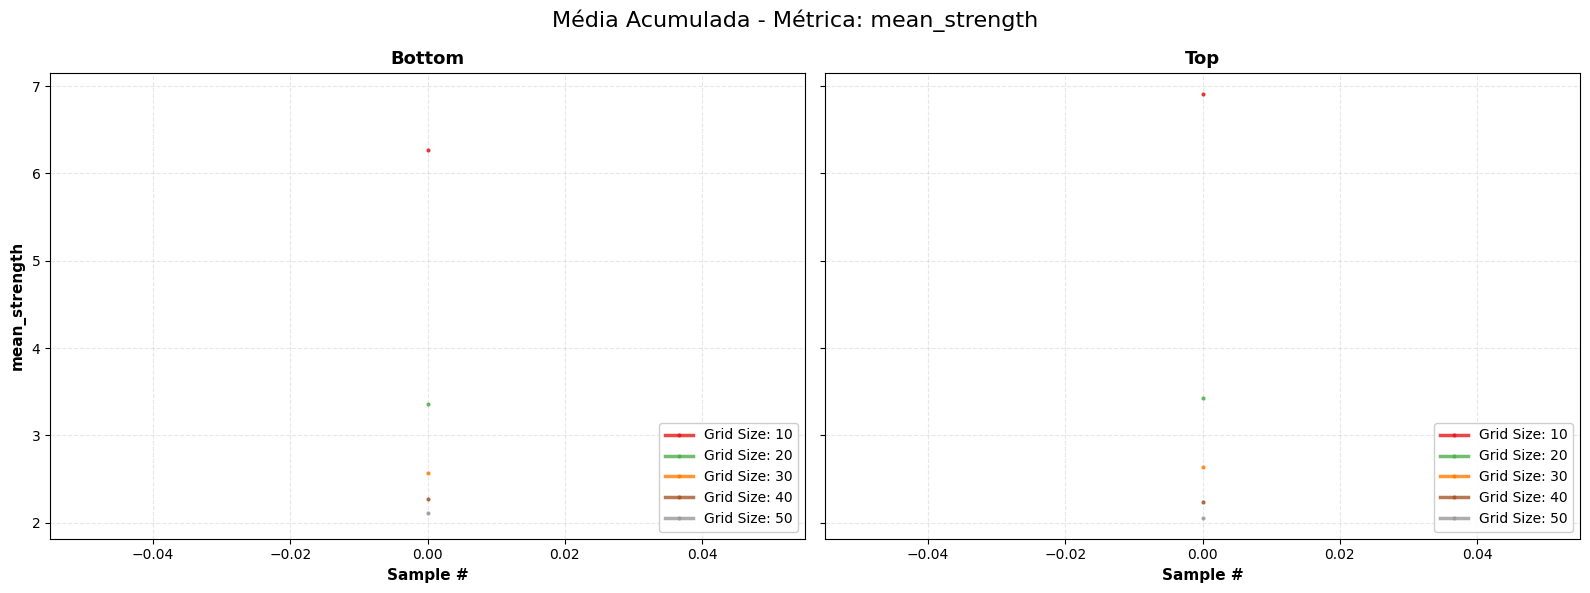

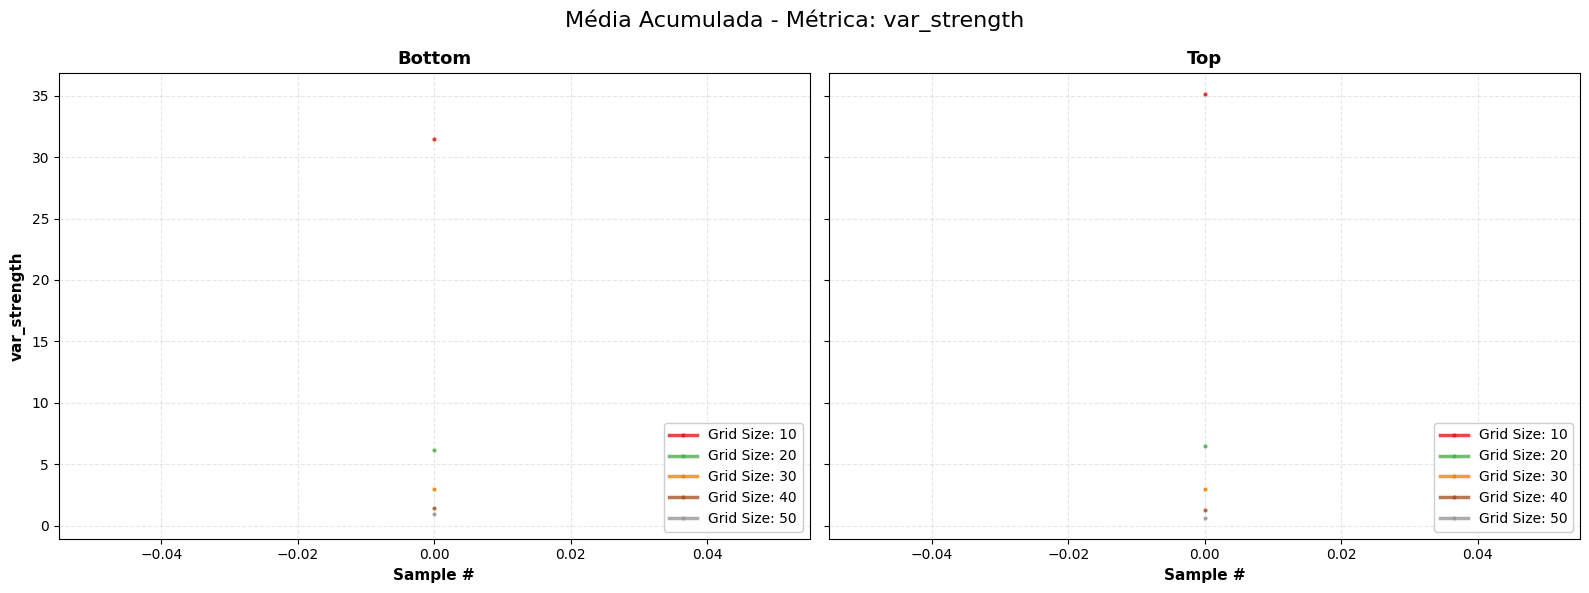

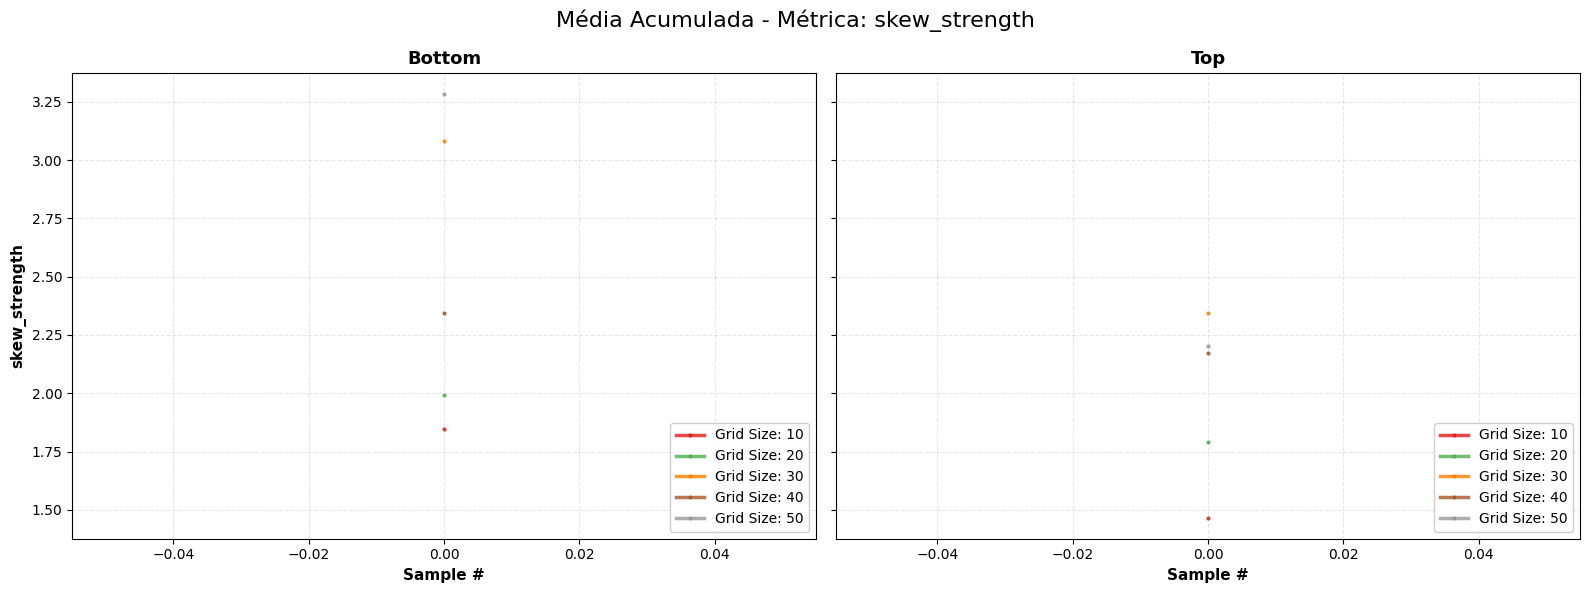

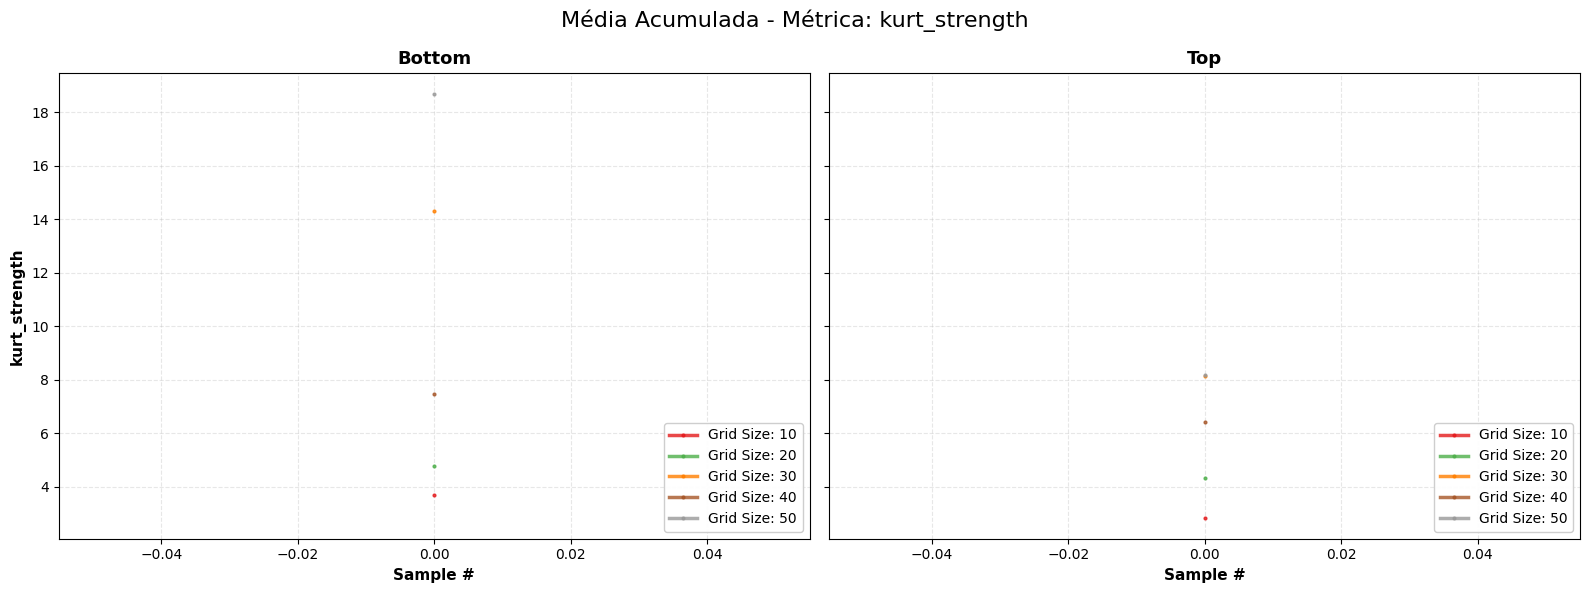

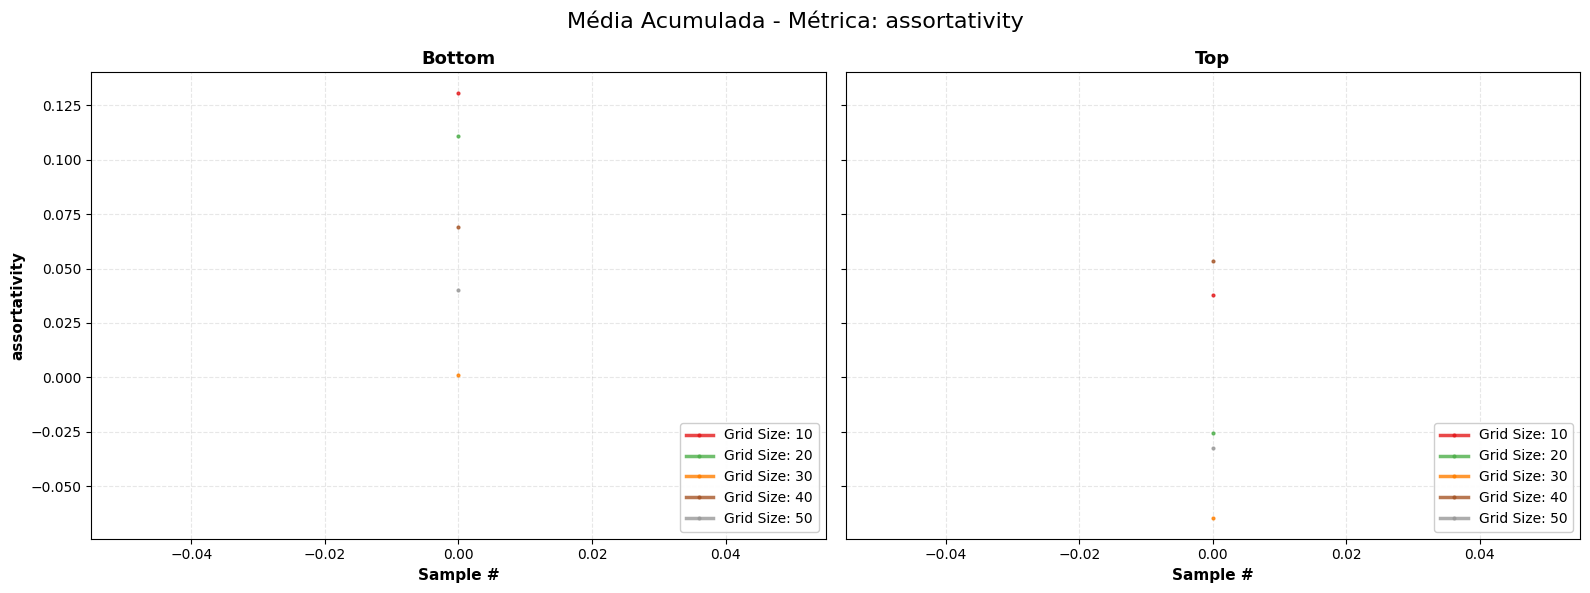

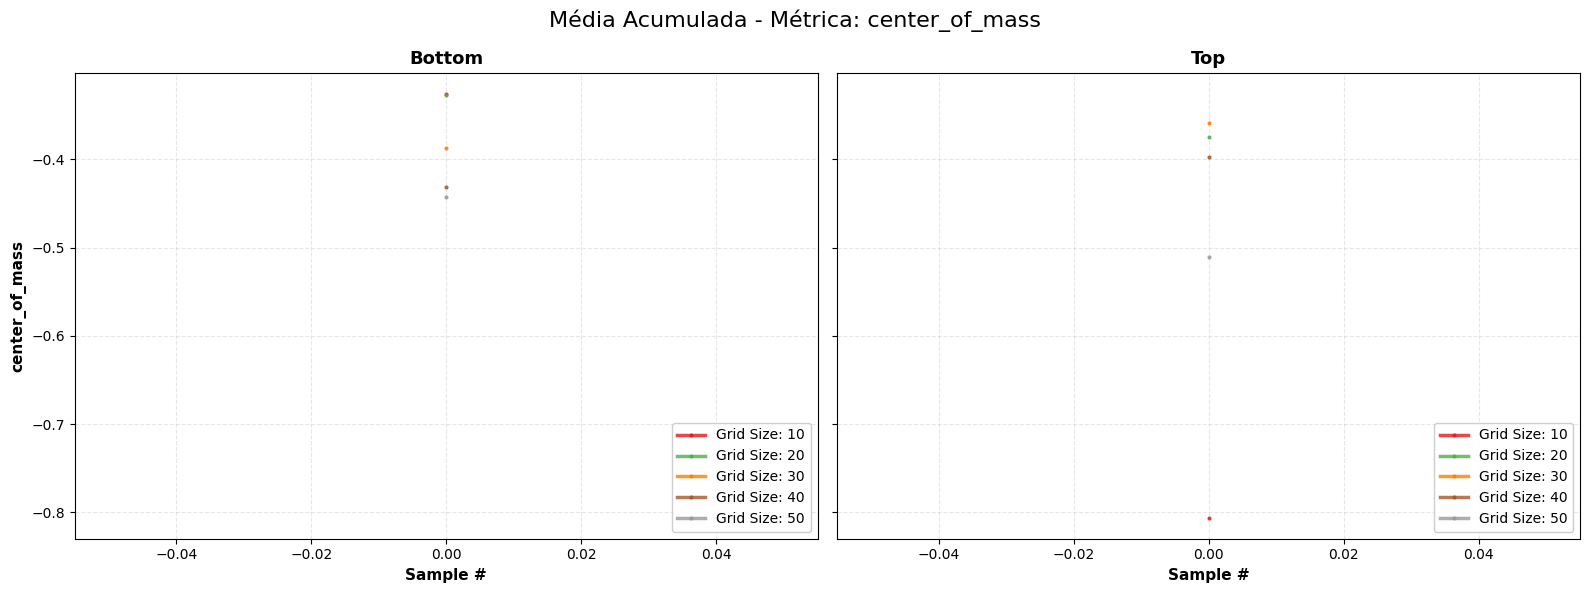


Foram gerados 16 gráficos de média acumulada.
Cada gráfico mostra: 2 subplots (true/fake) com curvas para cada grid_size
A curva mostra a evolução da média conforme os experimentos progridem.


In [13]:
metrics_df = pd.read_csv(metrics_path)

# Primeiro, vamos identificar quais colunas são métricas (excluir colunas de identificação)
metric_columns = [col for col in metrics_df.columns 
                  if col not in ['grid_size', 'sample', 'graph_label', 'model_name', 'label', 'graph_label', 'center_of_strength']] # The center_of_strength is completely nan

print(f"Total de métricas encontradas: {len(metric_columns)}")
print(f"Métricas: {metric_columns}\n")

plot_cumulative_mean_by_metric(metrics_df, metric_columns, GRID_SIZES)